In [80]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import tensorflow as tf
import tensorflow.keras.backend as K

from PIL import Image
from tqdm import tqdm
from tensorflow.keras.callbacks import ReduceLROnPlateau, LambdaCallback
from tensorflow.keras.layers import Lambda, Cropping2D, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import MSE, MAE
from tensorflow.keras.optimizers import Adam

from torch.utils.data import Dataset, DataLoader

In [3]:
tf.__version__

'1.14.0'

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
sess = tf.InteractiveSession()
K.set_session(sess)

### Preview some images

In [8]:
def prepare_image_initial(path):
    img = np.array(cv2.imread(path)[:,:,::-1])
    return Image.fromarray(img)    

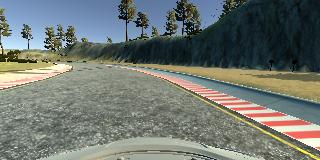

In [9]:
prepare_image_initial('./../_data/behavioral_cloning//good1/IMG/center_2019_10_30_09_35_55_229.jpg')

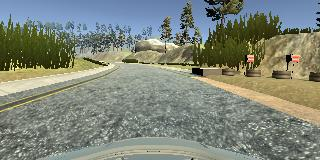

In [10]:
prepare_image_initial('./../_data/behavioral_cloning/good1/IMG/center_2019_10_30_09_36_25_490.jpg')

### Find eman image to determine Region Of Interest

100%|██████████| 3548/3548 [00:02<00:00, 1253.30it/s]


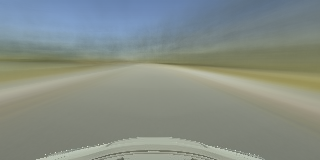

In [11]:
files = list(os.listdir('./../_data/behavioral_cloning/good1/IMG/'))
files = [ f for f in files if 'center' in f]

mean_img = np.zeros((160,320,3), dtype='long')
count = 0

with tqdm(total= len(files)) as p:
    for f in files:
        img = np.array(cv2.imread('./../_data/behavioral_cloning/good1/IMG/'+f)[:,:,::-1])
        mean_img += img
        count +=1
        p.update(1)
mean_img = mean_img // count
mean_img = mean_img.astype('uint8')
Image.fromarray(mean_img)

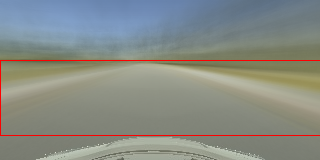

In [12]:
image_boundaries = mean_img.copy()
upper = 60
lower = 135
cv2.rectangle(image_boundaries,(0,upper),(320,lower), (255,0,0))
Image.fromarray(image_boundaries)

### Preview clipping result

In [13]:
def prepare_image(path):
    upper = 65
    lower = 135
    img = np.array(cv2.imread(path)[upper:lower,:,::-1])
    return Image.fromarray(img)
    

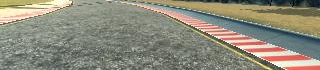

In [14]:
prepare_image('./../_data/behavioral_cloning/good1/IMG/center_2019_10_30_09_35_55_229.jpg')

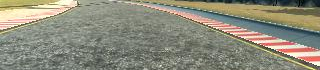

In [15]:
prepare_image('./../_data/behavioral_cloning/good1/IMG/left_2019_10_30_09_35_55_229.jpg')

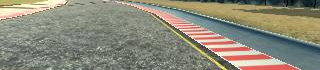

In [16]:
prepare_image('./../_data/behavioral_cloning/good1/IMG/right_2019_10_30_09_35_55_229.jpg')

In [17]:
def open_recording(folder_path):
    print("Reading:", folder_path)
    df = pd.read_csv(folder_path+'driving_log.csv', header=None)
    df.columns=['center','left','right','angle','throttle','break','speed']
    df['center'] = df['center'].apply(lambda x: x.split('/')[-1])
    df['left'] = df['left'].apply(lambda x: x.split('/')[-1])
    df['right'] = df['right'].apply(lambda x: x.split('/')[-1])
    df['path'] = [folder_path]*len(df)
    return df
    

In [37]:
df = open_recording('./../_data/behavioral_cloning/good1/')
df.head()

Reading: ./../_data/behavioral_cloning/good1/


,center,left,right,angle,throttle,break,speed,path
0,center_2019_10_30_09_35_55_229.jpg,left_2019_10_30_09_35_55_229.jpg,right_2019_10_30_09_35_55_229.jpg,0.00,0.0,0,1.806948,./../_data/behavioral_cloning/good1/
1,center_2019_10_30_09_35_55_304.jpg,left_2019_10_30_09_35_55_304.jpg,right_2019_10_30_09_35_55_304.jpg,0.00,0.0,0,1.791980,./../_data/behavioral_cloning/good1/
2,center_2019_10_30_09_35_55_419.jpg,left_2019_10_30_09_35_55_419.jpg,right_2019_10_30_09_35_55_419.jpg,0.00,0.0,0,1.769849,./../_data/behavioral_cloning/good1/
3,center_2019_10_30_09_35_55_486.jpg,left_2019_10_30_09_35_55_486.jpg,right_2019_10_30_09_35_55_486.jpg,0.00,0.0,0,1.758886,./../_data/behavioral_cloning/good1/
4,center_2019_10_30_09_35_55_566.jpg,left_2019_10_30_09_35_55_566.jpg,right_2019_10_30_09_35_55_566.jpg,-0.15,0.0,0,1.743292,./../_data/behavioral_cloning/good1/


Merge all recordings

In [19]:
df1 = open_recording('./../_data/behavioral_cloning/good1/')
df2 = open_recording('./../_data/behavioral_cloning/good2/')
#df3 = open_recording('./assets/good3o/')
df4 = open_recording('./../_data/behavioral_cloning/good4o/')

df = pd.concat([df1,df2,df4])

Reading: ./../_data/behavioral_cloning/good1/
Reading: ./../_data/behavioral_cloning/good2/
Reading: ./../_data/behavioral_cloning/good4o/


Check data histograms

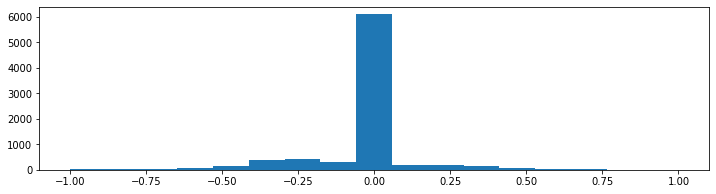

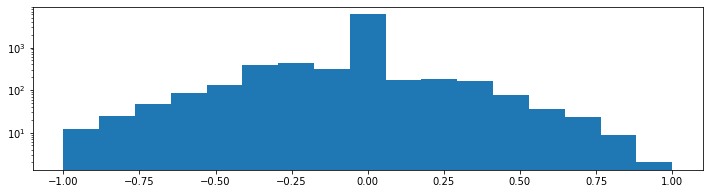

In [20]:
plt.figure(figsize=(12,3))
lin_hist = plt.hist(df['angle'], bins=17)
plt.figure(figsize=(12,3))
plt.hist(df['angle'], bins=17, log=True)
pass

In [21]:
from scipy.stats import norm
import math

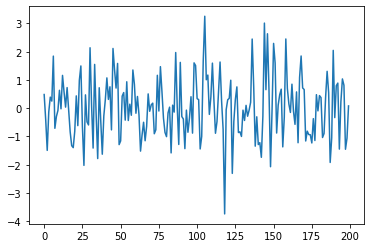

In [22]:
plt.plot(norm.rvs(loc=0,scale=1,size=200))

-0.030260149547166725 0.17551385956379997


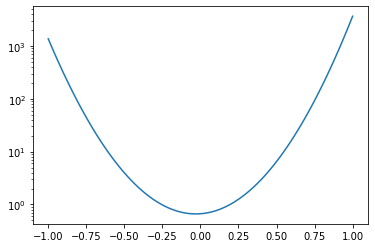

In [23]:
mu_x, std_x = norm.fit(df['angle'])
print(mu_x, std_x )
x_p = np.linspace(-1,1,100)
y_p = (1/std_x)*np.exp(-(((x_p-mu_x)/std_x)**2/2))/np.sqrt(2*(math.pi))

def get_weight_for_value(val, std_x, mu_x):
    y = (1/std_x)*np.exp(-(((val-mu_x)/std_x)**2/2))/np.sqrt(2*(math.pi))
    return 1/np.sqrt(y)
    
plt.plot(x_p, get_weight_for_value(x_p, std_x, mu_x))
plt.yscale("log")

Zero to non-zero angles

In [24]:
print("zero samples", len(df[df['angle']==0]))
print("non-zero samples", len(df[df['angle']!=0]))

zero samples 5841
non-zero samples 2358


# Dataset

In [25]:
class DrivingDataset(Dataset):
    def __init__(self, df):
        self.df= df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,index):
        row = self.df.iloc[index]
        path = row['path'] +'IMG/'
        img_l = cv2.imread(path+row['left'])[:,:,::-1]
        img_c = cv2.imread(path+row['center'])[:,:,::-1]
        img_r = cv2.imread(path+row['right'])[:,:,::-1]
        angle = row['angle']
        
        return np.float32(img_l), np.float32(img_c), np.float32(img_r), float(angle)

# Creating model

### Summarizer

In [87]:
def create_bins(num, low=-1,high=1, eps=sys.float_info.epsilon):
    total_len = high-low
    each_size = total_len / num
    print(f"Degree of freedom: +/-{(each_size/2):0.3f}")
    
    bins = []
    
    for i in range(num):
        e = 0
        if i>0:
            e=eps
        l = low+each_size*i+e
        h = low+each_size*(i+1)
        bins.append((l,h))
    
    return np.array(bins)
    
create_bins(17) 

Degree of freedom: +/-0.059


array([[-1.        , -0.88235294],
       [-0.88235294, -0.76470588],
       [-0.76470588, -0.64705882],
       [-0.64705882, -0.52941176],
       [-0.52941176, -0.41176471],
       [-0.41176471, -0.29411765],
       [-0.29411765, -0.17647059],
       [-0.17647059, -0.05882353],
       [-0.05882353,  0.05882353],
       [ 0.05882353,  0.17647059],
       [ 0.17647059,  0.29411765],
       [ 0.29411765,  0.41176471],
       [ 0.41176471,  0.52941176],
       [ 0.52941176,  0.64705882],
       [ 0.64705882,  0.76470588],
       [ 0.76470588,  0.88235294],
       [ 0.88235294,  1.        ]])

In [88]:
def value_to_bin(bins, value):
    for i,b in enumerate(bins):
        if value <= b[1]:
            return i
    return len(bins)-1

value_to_bin(create_bins(5),0)

Degree of freedom: +/-0.200


2

In [89]:
class EpochSummarizer():
    def __init__(self, model, loader, categories = 17):
        self.model = model
        self.loader = loader
        self.data = {}
        self.epoch = 0
        self.bins = create_bins(categories)
        
    def summarize(self, epoch, logs, side_coeff=0.2):
        self.data[self.epoch] = []
        
        with tqdm(desc="Summary progress", total= len(self.loader), leave=False) as p:
            for idx,(img_l,img_c,img_r,angle) in enumerate(self.loader):
                
                pred = model.predict(img_c)[0]               
                pred_bin = value_to_bin(self.bins, pred)
                angle_bin = value_to_bin(self.bins, angle)
                self.data[epoch].append( (pred, angle, pred_bin, angle_bin) )
                
                pred = model.predict(img_l)[0]               
                pred_bin = value_to_bin(self.bins, pred)
                angle_bin = value_to_bin(self.bins, angle+side_coeff)
                self.data[epoch].append( (pred, angle, pred_bin, angle_bin) )
                
                pred = model.predict(img_r)[0]               
                pred_bin = value_to_bin(self.bins, pred)
                angle_bin = value_to_bin(self.bins, angle-side_coeff)
                self.data[epoch].append( (pred, angle, pred_bin, angle_bin) )
                
                
                p.update()

        self.data[self.epoch] = np.array(self.data[self.epoch])
        self.accuracy(self.epoch)
        self.epoch += 1 
        
    def accuracy(self, epoch):
        data = self.data[epoch]
        
        for i,b in enumerate(self.bins):
            gt_selctor = data[:,3]==i
            nom = np.sum([data[gt_selctor][:,2]==i])
            dnom = np.sum(gt_selctor)
            acc = "n/a"
            if dnom>0:
                acc = f"{(nom/dnom):0.3f}"
            print(f"Accuracy in bin {i}({b[0]:0.3f}-{b[1]:0.3f}): {acc}", nom, dnom)

In [90]:
dataset = DrivingDataset(df)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

def data_generator(ld, epochs, side_coeff=0.2):
    for e in range(epochs):
        for img_l,img_c,img_r,angle in ld:
            yield img_c, angle
            yield img_l, angle+side_coeff
            yield img_r, angle-side_coeff

In [92]:
model = Sequential()
model.add(Lambda(lambda x: 2*((x / 255.0) - 0.5), input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((65,25), (0,0)), input_shape=(160,320,3)))
model.add(Conv2D(16,(5,5),padding='valid', activation='relu'))
model.add(Conv2D(32,(3,3),padding='valid', activation='relu'))
model.add(Conv2D(64,(3,3),padding='valid', activation='relu'))
model.add(Conv2D(128,(3,3),padding='valid', activation='relu'))
model.add(GlobalAveragePooling2D())
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation=None))

optimizer = Adam(learning_rate=0.001)
loss = MSE#weighted_loss
model.compile(optimizer, loss, metrics=[MAE])
model.summary()



Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_15 (Lambda)           (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_15 (Cropping2D)   (None, 70, 320, 3)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 66, 316, 16)       1216      
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 64, 314, 32)       4640      
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 62, 312, 64)       18496     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 60, 310, 128)      73856     
_________________________________________________________________
global_average_pooling2d_14  (None, 128)             

Degree of freedom: +/-0.059
Epoch 1/100
10643/10644 [============================>.] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.1362

Accuracy in bin 0(-1.000--0.882): 0.000 0 39
Accuracy in bin 1(-0.882--0.765): 0.000 0 47
Accuracy in bin 2(-0.765--0.647): 0.000 0 96
Accuracy in bin 3(-0.647--0.529): 0.000 0 217
Accuracy in bin 4(-0.529--0.412): 0.000 0 229
Accuracy in bin 5(-0.412--0.294): 0.034 20 588
Accuracy in bin 6(-0.294--0.176): 0.433 1293 2988
Accuracy in bin 7(-0.176--0.059): 0.295 98 332
Accuracy in bin 8(-0.059-0.059): 0.343 1054 3073
Accuracy in bin 9(0.059-0.176): 0.548 68 124
Accuracy in bin 10(0.176-0.294): 0.000 0 2681
Accuracy in bin 11(0.294-0.412): 0.000 0 105
Accuracy in bin 12(0.412-0.529): 0.000 0 48
Accuracy in bin 13(0.529-0.647): 0.000 0 38
Accuracy in bin 14(0.647-0.765): 0.000 0 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.000 0 5
10644/10644 [==============================] - 215s 20ms/step - loss: 0.0354 - mean_absolute_error: 0.1362
Epoch 2/100
    1/10644 [..............................] - ETA: 1:18 - loss: 0.0070 - mean_absolute_error: 0.0837

10642/10644 [============================>.] - ETA: 0s - loss: 0.0320 - mean_absolute_error: 0.1286

Accuracy in bin 0(-1.000--0.882): 0.000 0 39
Accuracy in bin 1(-0.882--0.765): 0.000 0 47
Accuracy in bin 2(-0.765--0.647): 0.000 0 96
Accuracy in bin 3(-0.647--0.529): 0.000 0 217
Accuracy in bin 4(-0.529--0.412): 0.000 0 229
Accuracy in bin 5(-0.412--0.294): 0.000 0 588
Accuracy in bin 6(-0.294--0.176): 0.272 812 2988
Accuracy in bin 7(-0.176--0.059): 0.304 101 332
Accuracy in bin 8(-0.059-0.059): 0.340 1044 3073
Accuracy in bin 9(0.059-0.176): 0.524 65 124
Accuracy in bin 10(0.176-0.294): 0.162 435 2681
Accuracy in bin 11(0.294-0.412): 0.000 0 105
Accuracy in bin 12(0.412-0.529): 0.000 0 48
Accuracy in bin 13(0.529-0.647): 0.000 0 38
Accuracy in bin 14(0.647-0.765): 0.000 0 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.000 0 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0320 - mean_absolute_error: 0.1286
Epoch 3/100
10642/10644 [============================>.] - ETA: 0s - loss: 0.0296 - mean_absolute_error: 0.1231

Accuracy in bin 0(-1.000--0.882): 0.000 0 39
Accuracy in bin 1(-0.882--0.765): 0.000 0 47
Accuracy in bin 2(-0.765--0.647): 0.000 0 96
Accuracy in bin 3(-0.647--0.529): 0.000 0 217
Accuracy in bin 4(-0.529--0.412): 0.017 4 229
Accuracy in bin 5(-0.412--0.294): 0.228 134 588
Accuracy in bin 6(-0.294--0.176): 0.442 1321 2988
Accuracy in bin 7(-0.176--0.059): 0.340 113 332
Accuracy in bin 8(-0.059-0.059): 0.283 870 3073
Accuracy in bin 9(0.059-0.176): 0.290 36 124
Accuracy in bin 10(0.176-0.294): 0.318 853 2681
Accuracy in bin 11(0.294-0.412): 0.000 0 105
Accuracy in bin 12(0.412-0.529): 0.000 0 48
Accuracy in bin 13(0.529-0.647): 0.000 0 38
Accuracy in bin 14(0.647-0.765): 0.000 0 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.000 0 5
10644/10644 [==============================] - 217s 20ms/step - loss: 0.0296 - mean_absolute_error: 0.1231
Epoch 4/100
    1/10644 [..............................] - ETA: 2:54 - loss: 0.0189 - mean_absolute_error: 0.1374

10638/10644 [============================>.] - ETA: 0s - loss: 0.0285 - mean_absolute_error: 0.1199

Accuracy in bin 0(-1.000--0.882): 0.000 0 39
Accuracy in bin 1(-0.882--0.765): 0.000 0 47
Accuracy in bin 2(-0.765--0.647): 0.000 0 96
Accuracy in bin 3(-0.647--0.529): 0.000 0 217
Accuracy in bin 4(-0.529--0.412): 0.000 0 229
Accuracy in bin 5(-0.412--0.294): 0.185 109 588
Accuracy in bin 6(-0.294--0.176): 0.553 1651 2988
Accuracy in bin 7(-0.176--0.059): 0.367 122 332
Accuracy in bin 8(-0.059-0.059): 0.244 749 3073
Accuracy in bin 9(0.059-0.176): 0.476 59 124
Accuracy in bin 10(0.176-0.294): 0.114 305 2681
Accuracy in bin 11(0.294-0.412): 0.000 0 105
Accuracy in bin 12(0.412-0.529): 0.000 0 48
Accuracy in bin 13(0.529-0.647): 0.000 0 38
Accuracy in bin 14(0.647-0.765): 0.000 0 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.000 0 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0284 - mean_absolute_error: 0.1199
Epoch 5/100
    1/10644 [..............................] - ETA: 2:50 - loss: 7.2239e-04 - mean_absolute_error: 0.026

10642/10644 [============================>.] - ETA: 0s - loss: 0.0271 - mean_absolute_error: 0.1174

Accuracy in bin 0(-1.000--0.882): 0.000 0 39
Accuracy in bin 1(-0.882--0.765): 0.000 0 47
Accuracy in bin 2(-0.765--0.647): 0.000 0 96
Accuracy in bin 3(-0.647--0.529): 0.000 0 217
Accuracy in bin 4(-0.529--0.412): 0.000 0 229
Accuracy in bin 5(-0.412--0.294): 0.107 63 588
Accuracy in bin 6(-0.294--0.176): 0.616 1841 2988
Accuracy in bin 7(-0.176--0.059): 0.358 119 332
Accuracy in bin 8(-0.059-0.059): 0.252 775 3073
Accuracy in bin 9(0.059-0.176): 0.524 65 124
Accuracy in bin 10(0.176-0.294): 0.044 117 2681
Accuracy in bin 11(0.294-0.412): 0.000 0 105
Accuracy in bin 12(0.412-0.529): 0.000 0 48
Accuracy in bin 13(0.529-0.647): 0.000 0 38
Accuracy in bin 14(0.647-0.765): 0.000 0 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.000 0 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0271 - mean_absolute_error: 0.1174
Epoch 6/100
    1/10644 [..............................] - ETA: 2:51 - loss: 0.0085 - mean_absolute_error: 0.0920

10637/10644 [============================>.] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.1154

Accuracy in bin 0(-1.000--0.882): 0.000 0 39
Accuracy in bin 1(-0.882--0.765): 0.000 0 47
Accuracy in bin 2(-0.765--0.647): 0.000 0 96
Accuracy in bin 3(-0.647--0.529): 0.009 2 217
Accuracy in bin 4(-0.529--0.412): 0.153 35 229
Accuracy in bin 5(-0.412--0.294): 0.418 246 588
Accuracy in bin 6(-0.294--0.176): 0.285 853 2988
Accuracy in bin 7(-0.176--0.059): 0.298 99 332
Accuracy in bin 8(-0.059-0.059): 0.185 569 3073
Accuracy in bin 9(0.059-0.176): 0.298 37 124
Accuracy in bin 10(0.176-0.294): 0.025 68 2681
Accuracy in bin 11(0.294-0.412): 0.000 0 105
Accuracy in bin 12(0.412-0.529): 0.000 0 48
Accuracy in bin 13(0.529-0.647): 0.000 0 38
Accuracy in bin 14(0.647-0.765): 0.000 0 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.000 0 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0263 - mean_absolute_error: 0.1153
Epoch 7/100
10643/10644 [============================>.] - ETA: 0s - loss: 0.0259 - mean_absolute_error: 0.1147

Accuracy in bin 0(-1.000--0.882): 0.000 0 39
Accuracy in bin 1(-0.882--0.765): 0.000 0 47
Accuracy in bin 2(-0.765--0.647): 0.000 0 96
Accuracy in bin 3(-0.647--0.529): 0.018 4 217
Accuracy in bin 4(-0.529--0.412): 0.083 19 229
Accuracy in bin 5(-0.412--0.294): 0.180 106 588
Accuracy in bin 6(-0.294--0.176): 0.562 1678 2988
Accuracy in bin 7(-0.176--0.059): 0.343 114 332
Accuracy in bin 8(-0.059-0.059): 0.269 826 3073
Accuracy in bin 9(0.059-0.176): 0.427 53 124
Accuracy in bin 10(0.176-0.294): 0.054 144 2681
Accuracy in bin 11(0.294-0.412): 0.029 3 105
Accuracy in bin 12(0.412-0.529): 0.000 0 48
Accuracy in bin 13(0.529-0.647): 0.000 0 38
Accuracy in bin 14(0.647-0.765): 0.000 0 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.000 0 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0259 - mean_absolute_error: 0.1147
Epoch 8/100
    1/10644 [..............................] - ETA: 1:27 - loss: 9.4512e-04 - mean_absolute_error: 0.03

10640/10644 [============================>.] - ETA: 0s - loss: 0.0255 - mean_absolute_error: 0.1134

Accuracy in bin 0(-1.000--0.882): 0.000 0 39
Accuracy in bin 1(-0.882--0.765): 0.000 0 47
Accuracy in bin 2(-0.765--0.647): 0.000 0 96
Accuracy in bin 3(-0.647--0.529): 0.000 0 217
Accuracy in bin 4(-0.529--0.412): 0.004 1 229
Accuracy in bin 5(-0.412--0.294): 0.124 73 588
Accuracy in bin 6(-0.294--0.176): 0.566 1692 2988
Accuracy in bin 7(-0.176--0.059): 0.316 105 332
Accuracy in bin 8(-0.059-0.059): 0.408 1253 3073
Accuracy in bin 9(0.059-0.176): 0.444 55 124
Accuracy in bin 10(0.176-0.294): 0.102 273 2681
Accuracy in bin 11(0.294-0.412): 0.124 13 105
Accuracy in bin 12(0.412-0.529): 0.021 1 48
Accuracy in bin 13(0.529-0.647): 0.000 0 38
Accuracy in bin 14(0.647-0.765): 0.000 0 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.000 0 5
10644/10644 [==============================] - 217s 20ms/step - loss: 0.0255 - mean_absolute_error: 0.1134
Epoch 9/100
10641/10644 [============================>.] - ETA: 0s - loss: 0.0249 - mean_absolute_error: 0.1129

Accuracy in bin 0(-1.000--0.882): 0.000 0 39
Accuracy in bin 1(-0.882--0.765): 0.000 0 47
Accuracy in bin 2(-0.765--0.647): 0.000 0 96
Accuracy in bin 3(-0.647--0.529): 0.000 0 217
Accuracy in bin 4(-0.529--0.412): 0.000 0 229
Accuracy in bin 5(-0.412--0.294): 0.070 41 588
Accuracy in bin 6(-0.294--0.176): 0.463 1382 2988
Accuracy in bin 7(-0.176--0.059): 0.328 109 332
Accuracy in bin 8(-0.059-0.059): 0.327 1004 3073
Accuracy in bin 9(0.059-0.176): 0.419 52 124
Accuracy in bin 10(0.176-0.294): 0.366 982 2681
Accuracy in bin 11(0.294-0.412): 0.095 10 105
Accuracy in bin 12(0.412-0.529): 0.000 0 48
Accuracy in bin 13(0.529-0.647): 0.000 0 38
Accuracy in bin 14(0.647-0.765): 0.000 0 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.000 0 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0249 - mean_absolute_error: 0.1129


Epoch 10/100
10642/10644 [============================>.] - ETA: 0s - loss: 0.0248 - mean_absolute_error: 0.1120

Accuracy in bin 0(-1.000--0.882): 0.000 0 39
Accuracy in bin 1(-0.882--0.765): 0.000 0 47
Accuracy in bin 2(-0.765--0.647): 0.000 0 96
Accuracy in bin 3(-0.647--0.529): 0.023 5 217
Accuracy in bin 4(-0.529--0.412): 0.179 41 229
Accuracy in bin 5(-0.412--0.294): 0.400 235 588
Accuracy in bin 6(-0.294--0.176): 0.295 880 2988
Accuracy in bin 7(-0.176--0.059): 0.286 95 332
Accuracy in bin 8(-0.059-0.059): 0.189 581 3073
Accuracy in bin 9(0.059-0.176): 0.210 26 124
Accuracy in bin 10(0.176-0.294): 0.010 27 2681
Accuracy in bin 11(0.294-0.412): 0.000 0 105
Accuracy in bin 12(0.412-0.529): 0.000 0 48
Accuracy in bin 13(0.529-0.647): 0.000 0 38
Accuracy in bin 14(0.647-0.765): 0.000 0 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.000 0 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0248 - mean_absolute_error: 0.1120
Epoch 11/100
    4/10644 [..............................] - ETA: 3:03 - loss: 0.0017 - mean_absolute_error: 0.0395

10641/10644 [============================>.] - ETA: 0s - loss: 0.0241 - mean_absolute_error: 0.1108

Accuracy in bin 0(-1.000--0.882): 0.231 9 39
Accuracy in bin 1(-0.882--0.765): 0.064 3 47
Accuracy in bin 2(-0.765--0.647): 0.083 8 96
Accuracy in bin 3(-0.647--0.529): 0.092 20 217
Accuracy in bin 4(-0.529--0.412): 0.175 40 229
Accuracy in bin 5(-0.412--0.294): 0.211 124 588
Accuracy in bin 6(-0.294--0.176): 0.365 1092 2988
Accuracy in bin 7(-0.176--0.059): 0.247 82 332
Accuracy in bin 8(-0.059-0.059): 0.353 1086 3073
Accuracy in bin 9(0.059-0.176): 0.355 44 124
Accuracy in bin 10(0.176-0.294): 0.393 1053 2681
Accuracy in bin 11(0.294-0.412): 0.248 26 105
Accuracy in bin 12(0.412-0.529): 0.062 3 48
Accuracy in bin 13(0.529-0.647): 0.000 0 38
Accuracy in bin 14(0.647-0.765): 0.000 0 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.000 0 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0241 - mean_absolute_error: 0.1108
Epoch 12/100
    1/10644 [..............................] - ETA: 2:55 - loss: 0.0061 - mean_absolute_error: 0.07

10640/10644 [============================>.] - ETA: 0s - loss: 0.0240 - mean_absolute_error: 0.1105

Accuracy in bin 0(-1.000--0.882): 0.000 0 39
Accuracy in bin 1(-0.882--0.765): 0.000 0 47
Accuracy in bin 2(-0.765--0.647): 0.010 1 96
Accuracy in bin 3(-0.647--0.529): 0.009 2 217
Accuracy in bin 4(-0.529--0.412): 0.048 11 229
Accuracy in bin 5(-0.412--0.294): 0.228 134 588
Accuracy in bin 6(-0.294--0.176): 0.524 1566 2988
Accuracy in bin 7(-0.176--0.059): 0.319 106 332
Accuracy in bin 8(-0.059-0.059): 0.396 1217 3073
Accuracy in bin 9(0.059-0.176): 0.379 47 124
Accuracy in bin 10(0.176-0.294): 0.261 699 2681
Accuracy in bin 11(0.294-0.412): 0.200 21 105
Accuracy in bin 12(0.412-0.529): 0.146 7 48
Accuracy in bin 13(0.529-0.647): 0.026 1 38
Accuracy in bin 14(0.647-0.765): 0.000 0 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.000 0 5
10644/10644 [==============================] - 217s 20ms/step - loss: 0.0239 - mean_absolute_error: 0.1105
Epoch 13/100
    5/10644 [..............................] - ETA: 2:52 - loss: 0.0263 - mean_absolute_error: 0.160

10640/10644 [============================>.] - ETA: 0s - loss: 0.0235 - mean_absolute_error: 0.1094

Accuracy in bin 0(-1.000--0.882): 0.000 0 39
Accuracy in bin 1(-0.882--0.765): 0.000 0 47
Accuracy in bin 2(-0.765--0.647): 0.010 1 96
Accuracy in bin 3(-0.647--0.529): 0.000 0 217
Accuracy in bin 4(-0.529--0.412): 0.009 2 229
Accuracy in bin 5(-0.412--0.294): 0.082 48 588
Accuracy in bin 6(-0.294--0.176): 0.317 947 2988
Accuracy in bin 7(-0.176--0.059): 0.208 69 332
Accuracy in bin 8(-0.059-0.059): 0.570 1752 3073
Accuracy in bin 9(0.059-0.176): 0.379 47 124
Accuracy in bin 10(0.176-0.294): 0.479 1285 2681
Accuracy in bin 11(0.294-0.412): 0.219 23 105
Accuracy in bin 12(0.412-0.529): 0.125 6 48
Accuracy in bin 13(0.529-0.647): 0.000 0 38
Accuracy in bin 14(0.647-0.765): 0.000 0 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.000 0 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0235 - mean_absolute_error: 0.1094


Epoch 14/100
10640/10644 [============================>.] - ETA: 0s - loss: 0.0236 - mean_absolute_error: 0.1091

Accuracy in bin 0(-1.000--0.882): 0.000 0 39
Accuracy in bin 1(-0.882--0.765): 0.000 0 47
Accuracy in bin 2(-0.765--0.647): 0.000 0 96
Accuracy in bin 3(-0.647--0.529): 0.055 12 217
Accuracy in bin 4(-0.529--0.412): 0.066 15 229
Accuracy in bin 5(-0.412--0.294): 0.189 111 588
Accuracy in bin 6(-0.294--0.176): 0.576 1721 2988
Accuracy in bin 7(-0.176--0.059): 0.304 101 332
Accuracy in bin 8(-0.059-0.059): 0.395 1213 3073
Accuracy in bin 9(0.059-0.176): 0.323 40 124
Accuracy in bin 10(0.176-0.294): 0.253 678 2681
Accuracy in bin 11(0.294-0.412): 0.238 25 105
Accuracy in bin 12(0.412-0.529): 0.104 5 48
Accuracy in bin 13(0.529-0.647): 0.026 1 38
Accuracy in bin 14(0.647-0.765): 0.000 0 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.000 0 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0236 - mean_absolute_error: 0.1090


Epoch 15/100
10636/10644 [============================>.] - ETA: 0s - loss: 0.0229 - mean_absolute_error: 0.1080

Accuracy in bin 0(-1.000--0.882): 0.000 0 39
Accuracy in bin 1(-0.882--0.765): 0.000 0 47
Accuracy in bin 2(-0.765--0.647): 0.031 3 96
Accuracy in bin 3(-0.647--0.529): 0.005 1 217
Accuracy in bin 4(-0.529--0.412): 0.017 4 229
Accuracy in bin 5(-0.412--0.294): 0.097 57 588
Accuracy in bin 6(-0.294--0.176): 0.491 1466 2988
Accuracy in bin 7(-0.176--0.059): 0.229 76 332
Accuracy in bin 8(-0.059-0.059): 0.501 1540 3073
Accuracy in bin 9(0.059-0.176): 0.468 58 124
Accuracy in bin 10(0.176-0.294): 0.376 1009 2681
Accuracy in bin 11(0.294-0.412): 0.248 26 105
Accuracy in bin 12(0.412-0.529): 0.042 2 48
Accuracy in bin 13(0.529-0.647): 0.000 0 38
Accuracy in bin 14(0.647-0.765): 0.000 0 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.000 0 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0230 - mean_absolute_error: 0.1080
Epoch 16/100
    1/10644 [..............................] - ETA: 2:48 - loss: 0.0020 - mean_absolute_error: 0.0443

10642/10644 [============================>.] - ETA: 0s - loss: 0.0225 - mean_absolute_error: 0.1062

Accuracy in bin 0(-1.000--0.882): 0.026 1 39
Accuracy in bin 1(-0.882--0.765): 0.000 0 47
Accuracy in bin 2(-0.765--0.647): 0.000 0 96
Accuracy in bin 3(-0.647--0.529): 0.005 1 217
Accuracy in bin 4(-0.529--0.412): 0.009 2 229
Accuracy in bin 5(-0.412--0.294): 0.087 51 588
Accuracy in bin 6(-0.294--0.176): 0.373 1116 2988
Accuracy in bin 7(-0.176--0.059): 0.214 71 332
Accuracy in bin 8(-0.059-0.059): 0.516 1586 3073
Accuracy in bin 9(0.059-0.176): 0.508 63 124
Accuracy in bin 10(0.176-0.294): 0.461 1237 2681
Accuracy in bin 11(0.294-0.412): 0.200 21 105
Accuracy in bin 12(0.412-0.529): 0.167 8 48
Accuracy in bin 13(0.529-0.647): 0.079 3 38
Accuracy in bin 14(0.647-0.765): 0.000 0 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.000 0 5
10644/10644 [==============================] - 217s 20ms/step - loss: 0.0225 - mean_absolute_error: 0.1063
Epoch 17/100
10642/10644 [============================>.] - ETA: 0s - loss: 0.0224 - mean_absolute_error: 0.1072

Accuracy in bin 0(-1.000--0.882): 0.103 4 39
Accuracy in bin 1(-0.882--0.765): 0.000 0 47
Accuracy in bin 2(-0.765--0.647): 0.073 7 96
Accuracy in bin 3(-0.647--0.529): 0.101 22 217
Accuracy in bin 4(-0.529--0.412): 0.114 26 229
Accuracy in bin 5(-0.412--0.294): 0.230 135 588
Accuracy in bin 6(-0.294--0.176): 0.509 1521 2988
Accuracy in bin 7(-0.176--0.059): 0.295 98 332
Accuracy in bin 8(-0.059-0.059): 0.372 1143 3073
Accuracy in bin 9(0.059-0.176): 0.355 44 124
Accuracy in bin 10(0.176-0.294): 0.451 1209 2681
Accuracy in bin 11(0.294-0.412): 0.295 31 105
Accuracy in bin 12(0.412-0.529): 0.042 2 48
Accuracy in bin 13(0.529-0.647): 0.000 0 38
Accuracy in bin 14(0.647-0.765): 0.000 0 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.000 0 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0224 - mean_absolute_error: 0.1072
Epoch 18/100
    1/10644 [..............................] - ETA: 1:17 - loss: 0.0471 - mean_absolute_error: 0.21

10643/10644 [============================>.] - ETA: 0s - loss: 0.0218 - mean_absolute_error: 0.1053

Accuracy in bin 0(-1.000--0.882): 0.026 1 39
Accuracy in bin 1(-0.882--0.765): 0.000 0 47
Accuracy in bin 2(-0.765--0.647): 0.010 1 96
Accuracy in bin 3(-0.647--0.529): 0.032 7 217
Accuracy in bin 4(-0.529--0.412): 0.052 12 229
Accuracy in bin 5(-0.412--0.294): 0.202 119 588
Accuracy in bin 6(-0.294--0.176): 0.508 1518 2988
Accuracy in bin 7(-0.176--0.059): 0.301 100 332
Accuracy in bin 8(-0.059-0.059): 0.539 1656 3073
Accuracy in bin 9(0.059-0.176): 0.403 50 124
Accuracy in bin 10(0.176-0.294): 0.102 273 2681
Accuracy in bin 11(0.294-0.412): 0.076 8 105
Accuracy in bin 12(0.412-0.529): 0.000 0 48
Accuracy in bin 13(0.529-0.647): 0.000 0 38
Accuracy in bin 14(0.647-0.765): 0.000 0 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.000 0 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0218 - mean_absolute_error: 0.1053
Epoch 19/100
    1/10644 [..............................] - ETA: 2:53 - loss: 0.0131 - mean_absolute_error: 0.1144

10640/10644 [============================>.] - ETA: 0s - loss: 0.0217 - mean_absolute_error: 0.1056

Accuracy in bin 0(-1.000--0.882): 0.026 1 39
Accuracy in bin 1(-0.882--0.765): 0.000 0 47
Accuracy in bin 2(-0.765--0.647): 0.000 0 96
Accuracy in bin 3(-0.647--0.529): 0.037 8 217
Accuracy in bin 4(-0.529--0.412): 0.096 22 229
Accuracy in bin 5(-0.412--0.294): 0.252 148 588
Accuracy in bin 6(-0.294--0.176): 0.543 1622 2988
Accuracy in bin 7(-0.176--0.059): 0.328 109 332
Accuracy in bin 8(-0.059-0.059): 0.420 1292 3073
Accuracy in bin 9(0.059-0.176): 0.379 47 124
Accuracy in bin 10(0.176-0.294): 0.300 803 2681
Accuracy in bin 11(0.294-0.412): 0.124 13 105
Accuracy in bin 12(0.412-0.529): 0.042 2 48
Accuracy in bin 13(0.529-0.647): 0.026 1 38
Accuracy in bin 14(0.647-0.765): 0.000 0 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.000 0 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0217 - mean_absolute_error: 0.1056
Epoch 20/100
    1/10644 [..............................] - ETA: 2:55 - loss: 0.0913 - mean_absolute_error: 0.302

10641/10644 [============================>.] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.1041

Accuracy in bin 0(-1.000--0.882): 0.000 0 39
Accuracy in bin 1(-0.882--0.765): 0.000 0 47
Accuracy in bin 2(-0.765--0.647): 0.010 1 96
Accuracy in bin 3(-0.647--0.529): 0.023 5 217
Accuracy in bin 4(-0.529--0.412): 0.092 21 229
Accuracy in bin 5(-0.412--0.294): 0.277 163 588
Accuracy in bin 6(-0.294--0.176): 0.539 1610 2988
Accuracy in bin 7(-0.176--0.059): 0.292 97 332
Accuracy in bin 8(-0.059-0.059): 0.388 1192 3073
Accuracy in bin 9(0.059-0.176): 0.452 56 124
Accuracy in bin 10(0.176-0.294): 0.208 557 2681
Accuracy in bin 11(0.294-0.412): 0.152 16 105
Accuracy in bin 12(0.412-0.529): 0.229 11 48
Accuracy in bin 13(0.529-0.647): 0.132 5 38
Accuracy in bin 14(0.647-0.765): 0.040 1 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.000 0 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0213 - mean_absolute_error: 0.1041
Epoch 21/100
10643/10644 [============================>.] - ETA: 0s - loss: 0.0207 - mean_absolute_error: 0.1028

Accuracy in bin 0(-1.000--0.882): 0.000 0 39
Accuracy in bin 1(-0.882--0.765): 0.000 0 47
Accuracy in bin 2(-0.765--0.647): 0.010 1 96
Accuracy in bin 3(-0.647--0.529): 0.028 6 217
Accuracy in bin 4(-0.529--0.412): 0.057 13 229
Accuracy in bin 5(-0.412--0.294): 0.151 89 588
Accuracy in bin 6(-0.294--0.176): 0.597 1783 2988
Accuracy in bin 7(-0.176--0.059): 0.337 112 332
Accuracy in bin 8(-0.059-0.059): 0.421 1293 3073
Accuracy in bin 9(0.059-0.176): 0.452 56 124
Accuracy in bin 10(0.176-0.294): 0.278 746 2681
Accuracy in bin 11(0.294-0.412): 0.238 25 105
Accuracy in bin 12(0.412-0.529): 0.104 5 48
Accuracy in bin 13(0.529-0.647): 0.000 0 38
Accuracy in bin 14(0.647-0.765): 0.000 0 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.000 0 5
10644/10644 [==============================] - 217s 20ms/step - loss: 0.0207 - mean_absolute_error: 0.1027
Epoch 22/100
10642/10644 [============================>.] - ETA: 0s - loss: 0.0207 - mean_absolute_error: 0.1033

Accuracy in bin 0(-1.000--0.882): 0.205 8 39
Accuracy in bin 1(-0.882--0.765): 0.085 4 47
Accuracy in bin 2(-0.765--0.647): 0.125 12 96
Accuracy in bin 3(-0.647--0.529): 0.083 18 217
Accuracy in bin 4(-0.529--0.412): 0.175 40 229
Accuracy in bin 5(-0.412--0.294): 0.228 134 588
Accuracy in bin 6(-0.294--0.176): 0.467 1394 2988
Accuracy in bin 7(-0.176--0.059): 0.250 83 332
Accuracy in bin 8(-0.059-0.059): 0.417 1280 3073
Accuracy in bin 9(0.059-0.176): 0.379 47 124
Accuracy in bin 10(0.176-0.294): 0.158 424 2681
Accuracy in bin 11(0.294-0.412): 0.086 9 105
Accuracy in bin 12(0.412-0.529): 0.000 0 48
Accuracy in bin 13(0.529-0.647): 0.000 0 38
Accuracy in bin 14(0.647-0.765): 0.000 0 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.000 0 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0207 - mean_absolute_error: 0.1033
Epoch 23/100
    5/10644 [..............................] - ETA: 2:53 - loss: 0.0146 - mean_absolute_error: 0.116

10641/10644 [============================>.] - ETA: 0s - loss: 0.0201 - mean_absolute_error: 0.1020

Accuracy in bin 0(-1.000--0.882): 0.077 3 39
Accuracy in bin 1(-0.882--0.765): 0.000 0 47
Accuracy in bin 2(-0.765--0.647): 0.042 4 96
Accuracy in bin 3(-0.647--0.529): 0.041 9 217
Accuracy in bin 4(-0.529--0.412): 0.052 12 229
Accuracy in bin 5(-0.412--0.294): 0.085 50 588
Accuracy in bin 6(-0.294--0.176): 0.409 1221 2988
Accuracy in bin 7(-0.176--0.059): 0.262 87 332
Accuracy in bin 8(-0.059-0.059): 0.570 1752 3073
Accuracy in bin 9(0.059-0.176): 0.298 37 124
Accuracy in bin 10(0.176-0.294): 0.530 1420 2681
Accuracy in bin 11(0.294-0.412): 0.248 26 105
Accuracy in bin 12(0.412-0.529): 0.292 14 48
Accuracy in bin 13(0.529-0.647): 0.132 5 38
Accuracy in bin 14(0.647-0.765): 0.200 5 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.000 0 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0201 - mean_absolute_error: 0.1020
Epoch 24/100
10642/10644 [============================>.] - ETA: 0s - loss: 0.0200 - mean_absolute_error: 0.1012

Accuracy in bin 0(-1.000--0.882): 0.051 2 39
Accuracy in bin 1(-0.882--0.765): 0.021 1 47
Accuracy in bin 2(-0.765--0.647): 0.010 1 96
Accuracy in bin 3(-0.647--0.529): 0.046 10 217
Accuracy in bin 4(-0.529--0.412): 0.100 23 229
Accuracy in bin 5(-0.412--0.294): 0.230 135 588
Accuracy in bin 6(-0.294--0.176): 0.620 1852 2988
Accuracy in bin 7(-0.176--0.059): 0.401 133 332
Accuracy in bin 8(-0.059-0.059): 0.241 742 3073
Accuracy in bin 9(0.059-0.176): 0.403 50 124
Accuracy in bin 10(0.176-0.294): 0.222 596 2681
Accuracy in bin 11(0.294-0.412): 0.257 27 105
Accuracy in bin 12(0.412-0.529): 0.104 5 48
Accuracy in bin 13(0.529-0.647): 0.026 1 38
Accuracy in bin 14(0.647-0.765): 0.000 0 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.000 0 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0200 - mean_absolute_error: 0.1012
Epoch 25/100
10641/10644 [============================>.] - ETA: 0s - loss: 0.0196 - mean_absolute_error: 0.1003

Accuracy in bin 0(-1.000--0.882): 0.000 0 39
Accuracy in bin 1(-0.882--0.765): 0.000 0 47
Accuracy in bin 2(-0.765--0.647): 0.000 0 96
Accuracy in bin 3(-0.647--0.529): 0.000 0 217
Accuracy in bin 4(-0.529--0.412): 0.013 3 229
Accuracy in bin 5(-0.412--0.294): 0.061 36 588
Accuracy in bin 6(-0.294--0.176): 0.488 1457 2988
Accuracy in bin 7(-0.176--0.059): 0.256 85 332
Accuracy in bin 8(-0.059-0.059): 0.550 1690 3073
Accuracy in bin 9(0.059-0.176): 0.500 62 124
Accuracy in bin 10(0.176-0.294): 0.390 1045 2681
Accuracy in bin 11(0.294-0.412): 0.181 19 105
Accuracy in bin 12(0.412-0.529): 0.021 1 48
Accuracy in bin 13(0.529-0.647): 0.053 2 38
Accuracy in bin 14(0.647-0.765): 0.040 1 25
Accuracy in bin 15(0.765-0.882): 0.111 1 9
Accuracy in bin 16(0.882-1.000): 0.000 0 5
10644/10644 [==============================] - 217s 20ms/step - loss: 0.0196 - mean_absolute_error: 0.1003
Epoch 26/100
    1/10644 [..............................] - ETA: 1:13 - loss: 8.9337e-07 - mean_absolute_error: 9.4

10642/10644 [============================>.] - ETA: 0s - loss: 0.0187 - mean_absolute_error: 0.0983

Accuracy in bin 0(-1.000--0.882): 0.051 2 39
Accuracy in bin 1(-0.882--0.765): 0.021 1 47
Accuracy in bin 2(-0.765--0.647): 0.031 3 96
Accuracy in bin 3(-0.647--0.529): 0.041 9 217
Accuracy in bin 4(-0.529--0.412): 0.100 23 229
Accuracy in bin 5(-0.412--0.294): 0.168 99 588
Accuracy in bin 6(-0.294--0.176): 0.548 1638 2988
Accuracy in bin 7(-0.176--0.059): 0.250 83 332
Accuracy in bin 8(-0.059-0.059): 0.445 1368 3073
Accuracy in bin 9(0.059-0.176): 0.323 40 124
Accuracy in bin 10(0.176-0.294): 0.512 1373 2681
Accuracy in bin 11(0.294-0.412): 0.410 43 105
Accuracy in bin 12(0.412-0.529): 0.062 3 48
Accuracy in bin 13(0.529-0.647): 0.000 0 38
Accuracy in bin 14(0.647-0.765): 0.080 2 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.000 0 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0187 - mean_absolute_error: 0.0983
Epoch 27/100
    1/10644 [..............................] - ETA: 2:45 - loss: 0.0096 - mean_absolute_error: 0.0979

10643/10644 [============================>.] - ETA: 0s - loss: 0.0183 - mean_absolute_error: 0.0974

Accuracy in bin 0(-1.000--0.882): 0.410 16 39
Accuracy in bin 1(-0.882--0.765): 0.128 6 47
Accuracy in bin 2(-0.765--0.647): 0.062 6 96
Accuracy in bin 3(-0.647--0.529): 0.083 18 217
Accuracy in bin 4(-0.529--0.412): 0.135 31 229
Accuracy in bin 5(-0.412--0.294): 0.145 85 588
Accuracy in bin 6(-0.294--0.176): 0.491 1466 2988
Accuracy in bin 7(-0.176--0.059): 0.298 99 332
Accuracy in bin 8(-0.059-0.059): 0.511 1569 3073
Accuracy in bin 9(0.059-0.176): 0.411 51 124
Accuracy in bin 10(0.176-0.294): 0.455 1219 2681
Accuracy in bin 11(0.294-0.412): 0.343 36 105
Accuracy in bin 12(0.412-0.529): 0.250 12 48
Accuracy in bin 13(0.529-0.647): 0.132 5 38
Accuracy in bin 14(0.647-0.765): 0.000 0 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.000 0 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0183 - mean_absolute_error: 0.0974
Epoch 28/100
    1/10644 [..............................] - ETA: 2:48 - loss: 0.0148 - mean_absolute_error: 0.1

10642/10644 [============================>.] - ETA: 0s - loss: 0.0181 - mean_absolute_error: 0.0967

Accuracy in bin 0(-1.000--0.882): 0.077 3 39
Accuracy in bin 1(-0.882--0.765): 0.021 1 47
Accuracy in bin 2(-0.765--0.647): 0.000 0 96
Accuracy in bin 3(-0.647--0.529): 0.032 7 217
Accuracy in bin 4(-0.529--0.412): 0.013 3 229
Accuracy in bin 5(-0.412--0.294): 0.102 60 588
Accuracy in bin 6(-0.294--0.176): 0.442 1321 2988
Accuracy in bin 7(-0.176--0.059): 0.220 73 332
Accuracy in bin 8(-0.059-0.059): 0.678 2084 3073
Accuracy in bin 9(0.059-0.176): 0.403 50 124
Accuracy in bin 10(0.176-0.294): 0.331 888 2681
Accuracy in bin 11(0.294-0.412): 0.267 28 105
Accuracy in bin 12(0.412-0.529): 0.167 8 48
Accuracy in bin 13(0.529-0.647): 0.079 3 38
Accuracy in bin 14(0.647-0.765): 0.000 0 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.000 0 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0181 - mean_absolute_error: 0.0967


Epoch 29/100
10641/10644 [============================>.] - ETA: 0s - loss: 0.0177 - mean_absolute_error: 0.0956

Accuracy in bin 0(-1.000--0.882): 0.410 16 39
Accuracy in bin 1(-0.882--0.765): 0.085 4 47
Accuracy in bin 2(-0.765--0.647): 0.083 8 96
Accuracy in bin 3(-0.647--0.529): 0.092 20 217
Accuracy in bin 4(-0.529--0.412): 0.127 29 229
Accuracy in bin 5(-0.412--0.294): 0.139 82 588
Accuracy in bin 6(-0.294--0.176): 0.518 1547 2988
Accuracy in bin 7(-0.176--0.059): 0.289 96 332
Accuracy in bin 8(-0.059-0.059): 0.566 1739 3073
Accuracy in bin 9(0.059-0.176): 0.411 51 124
Accuracy in bin 10(0.176-0.294): 0.430 1153 2681
Accuracy in bin 11(0.294-0.412): 0.286 30 105
Accuracy in bin 12(0.412-0.529): 0.188 9 48
Accuracy in bin 13(0.529-0.647): 0.079 3 38
Accuracy in bin 14(0.647-0.765): 0.080 2 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.000 0 5
10644/10644 [==============================] - 217s 20ms/step - loss: 0.0177 - mean_absolute_error: 0.0956
Epoch 30/100
    4/10644 [..............................] - ETA: 3:05 - loss: 0.0206 - mean_absolute_error: 0.13

10641/10644 [============================>.] - ETA: 0s - loss: 0.0170 - mean_absolute_error: 0.0944

Accuracy in bin 0(-1.000--0.882): 0.179 7 39
Accuracy in bin 1(-0.882--0.765): 0.043 2 47
Accuracy in bin 2(-0.765--0.647): 0.073 7 96
Accuracy in bin 3(-0.647--0.529): 0.101 22 217
Accuracy in bin 4(-0.529--0.412): 0.100 23 229
Accuracy in bin 5(-0.412--0.294): 0.175 103 588
Accuracy in bin 6(-0.294--0.176): 0.581 1736 2988
Accuracy in bin 7(-0.176--0.059): 0.310 103 332
Accuracy in bin 8(-0.059-0.059): 0.513 1575 3073
Accuracy in bin 9(0.059-0.176): 0.363 45 124
Accuracy in bin 10(0.176-0.294): 0.584 1565 2681
Accuracy in bin 11(0.294-0.412): 0.324 34 105
Accuracy in bin 12(0.412-0.529): 0.188 9 48
Accuracy in bin 13(0.529-0.647): 0.237 9 38
Accuracy in bin 14(0.647-0.765): 0.200 5 25
Accuracy in bin 15(0.765-0.882): 0.111 1 9
Accuracy in bin 16(0.882-1.000): 0.400 2 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0170 - mean_absolute_error: 0.0944
Epoch 31/100
    1/10644 [..............................] - ETA: 1:57 - loss: 0.0020 - mean_absolute_error: 0.0

10641/10644 [============================>.] - ETA: 0s - loss: 0.0168 - mean_absolute_error: 0.0931

Accuracy in bin 0(-1.000--0.882): 0.205 8 39
Accuracy in bin 1(-0.882--0.765): 0.106 5 47
Accuracy in bin 2(-0.765--0.647): 0.042 4 96
Accuracy in bin 3(-0.647--0.529): 0.074 16 217
Accuracy in bin 4(-0.529--0.412): 0.114 26 229
Accuracy in bin 5(-0.412--0.294): 0.207 122 588
Accuracy in bin 6(-0.294--0.176): 0.552 1649 2988
Accuracy in bin 7(-0.176--0.059): 0.340 113 332
Accuracy in bin 8(-0.059-0.059): 0.364 1120 3073
Accuracy in bin 9(0.059-0.176): 0.427 53 124
Accuracy in bin 10(0.176-0.294): 0.538 1442 2681
Accuracy in bin 11(0.294-0.412): 0.400 42 105
Accuracy in bin 12(0.412-0.529): 0.208 10 48
Accuracy in bin 13(0.529-0.647): 0.053 2 38
Accuracy in bin 14(0.647-0.765): 0.040 1 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.000 0 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0168 - mean_absolute_error: 0.0931
Epoch 32/100
    1/10644 [..............................] - ETA: 1:22 - loss: 1.2999e-05 - mean_absolute_error

10642/10644 [============================>.] - ETA: 0s - loss: 0.0162 - mean_absolute_error: 0.0921

Accuracy in bin 0(-1.000--0.882): 0.308 12 39
Accuracy in bin 1(-0.882--0.765): 0.064 3 47
Accuracy in bin 2(-0.765--0.647): 0.083 8 96
Accuracy in bin 3(-0.647--0.529): 0.065 14 217
Accuracy in bin 4(-0.529--0.412): 0.079 18 229
Accuracy in bin 5(-0.412--0.294): 0.156 92 588
Accuracy in bin 6(-0.294--0.176): 0.489 1462 2988
Accuracy in bin 7(-0.176--0.059): 0.208 69 332
Accuracy in bin 8(-0.059-0.059): 0.583 1791 3073
Accuracy in bin 9(0.059-0.176): 0.508 63 124
Accuracy in bin 10(0.176-0.294): 0.478 1282 2681
Accuracy in bin 11(0.294-0.412): 0.314 33 105
Accuracy in bin 12(0.412-0.529): 0.104 5 48
Accuracy in bin 13(0.529-0.647): 0.079 3 38
Accuracy in bin 14(0.647-0.765): 0.040 1 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.200 1 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0162 - mean_absolute_error: 0.0921


Epoch 33/100
10641/10644 [============================>.] - ETA: 0s - loss: 0.0160 - mean_absolute_error: 0.0911

Accuracy in bin 0(-1.000--0.882): 0.000 0 39
Accuracy in bin 1(-0.882--0.765): 0.000 0 47
Accuracy in bin 2(-0.765--0.647): 0.000 0 96
Accuracy in bin 3(-0.647--0.529): 0.009 2 217
Accuracy in bin 4(-0.529--0.412): 0.017 4 229
Accuracy in bin 5(-0.412--0.294): 0.068 40 588
Accuracy in bin 6(-0.294--0.176): 0.593 1772 2988
Accuracy in bin 7(-0.176--0.059): 0.425 141 332
Accuracy in bin 8(-0.059-0.059): 0.391 1202 3073
Accuracy in bin 9(0.059-0.176): 0.476 59 124
Accuracy in bin 10(0.176-0.294): 0.329 883 2681
Accuracy in bin 11(0.294-0.412): 0.210 22 105
Accuracy in bin 12(0.412-0.529): 0.208 10 48
Accuracy in bin 13(0.529-0.647): 0.053 2 38
Accuracy in bin 14(0.647-0.765): 0.000 0 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.200 1 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0160 - mean_absolute_error: 0.0911
Epoch 34/100
    1/10644 [..............................] - ETA: 1:09 - loss: 4.9186e-05 - mean_absolute_error: 0.

10641/10644 [============================>.] - ETA: 0s - loss: 0.0153 - mean_absolute_error: 0.0898

Accuracy in bin 0(-1.000--0.882): 0.282 11 39
Accuracy in bin 1(-0.882--0.765): 0.043 2 47
Accuracy in bin 2(-0.765--0.647): 0.115 11 96
Accuracy in bin 3(-0.647--0.529): 0.097 21 217
Accuracy in bin 4(-0.529--0.412): 0.105 24 229
Accuracy in bin 5(-0.412--0.294): 0.121 71 588
Accuracy in bin 6(-0.294--0.176): 0.326 975 2988
Accuracy in bin 7(-0.176--0.059): 0.313 104 332
Accuracy in bin 8(-0.059-0.059): 0.532 1634 3073
Accuracy in bin 9(0.059-0.176): 0.460 57 124
Accuracy in bin 10(0.176-0.294): 0.416 1116 2681
Accuracy in bin 11(0.294-0.412): 0.410 43 105
Accuracy in bin 12(0.412-0.529): 0.312 15 48
Accuracy in bin 13(0.529-0.647): 0.342 13 38
Accuracy in bin 14(0.647-0.765): 0.120 3 25
Accuracy in bin 15(0.765-0.882): 0.111 1 9
Accuracy in bin 16(0.882-1.000): 0.200 1 5
10644/10644 [==============================] - 217s 20ms/step - loss: 0.0153 - mean_absolute_error: 0.0898
Epoch 35/100
    1/10644 [..............................] - ETA: 3:11 - loss: 0.0645 - mean_absolute_error: 0

10642/10644 [============================>.] - ETA: 0s - loss: 0.0147 - mean_absolute_error: 0.0878

Accuracy in bin 0(-1.000--0.882): 0.436 17 39
Accuracy in bin 1(-0.882--0.765): 0.170 8 47
Accuracy in bin 2(-0.765--0.647): 0.083 8 96
Accuracy in bin 3(-0.647--0.529): 0.134 29 217
Accuracy in bin 4(-0.529--0.412): 0.127 29 229
Accuracy in bin 5(-0.412--0.294): 0.187 110 588
Accuracy in bin 6(-0.294--0.176): 0.512 1530 2988
Accuracy in bin 7(-0.176--0.059): 0.334 111 332
Accuracy in bin 8(-0.059-0.059): 0.642 1974 3073
Accuracy in bin 9(0.059-0.176): 0.435 54 124
Accuracy in bin 10(0.176-0.294): 0.289 774 2681
Accuracy in bin 11(0.294-0.412): 0.267 28 105
Accuracy in bin 12(0.412-0.529): 0.146 7 48
Accuracy in bin 13(0.529-0.647): 0.079 3 38
Accuracy in bin 14(0.647-0.765): 0.040 1 25
Accuracy in bin 15(0.765-0.882): 0.111 1 9
Accuracy in bin 16(0.882-1.000): 0.200 1 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0147 - mean_absolute_error: 0.0878
Epoch 36/100
    1/10644 [..............................] - ETA: 3:07 - loss: 0.1827 - mean_absolute_error: 0.4

10642/10644 [============================>.] - ETA: 0s - loss: 0.0146 - mean_absolute_error: 0.0876

Accuracy in bin 0(-1.000--0.882): 0.179 7 39
Accuracy in bin 1(-0.882--0.765): 0.085 4 47
Accuracy in bin 2(-0.765--0.647): 0.052 5 96
Accuracy in bin 3(-0.647--0.529): 0.046 10 217
Accuracy in bin 4(-0.529--0.412): 0.109 25 229
Accuracy in bin 5(-0.412--0.294): 0.204 120 588
Accuracy in bin 6(-0.294--0.176): 0.622 1859 2988
Accuracy in bin 7(-0.176--0.059): 0.440 146 332
Accuracy in bin 8(-0.059-0.059): 0.359 1102 3073
Accuracy in bin 9(0.059-0.176): 0.419 52 124
Accuracy in bin 10(0.176-0.294): 0.388 1039 2681
Accuracy in bin 11(0.294-0.412): 0.276 29 105
Accuracy in bin 12(0.412-0.529): 0.354 17 48
Accuracy in bin 13(0.529-0.647): 0.105 4 38
Accuracy in bin 14(0.647-0.765): 0.200 5 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.200 1 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0146 - mean_absolute_error: 0.0876
Epoch 37/100
    9/10644 [..............................] - ETA: 1:15 - loss: 0.0020 - mean_absolute_error: 0.

10643/10644 [============================>.] - ETA: 0s - loss: 0.0139 - mean_absolute_error: 0.0858

Accuracy in bin 0(-1.000--0.882): 0.051 2 39
Accuracy in bin 1(-0.882--0.765): 0.000 0 47
Accuracy in bin 2(-0.765--0.647): 0.042 4 96
Accuracy in bin 3(-0.647--0.529): 0.018 4 217
Accuracy in bin 4(-0.529--0.412): 0.035 8 229
Accuracy in bin 5(-0.412--0.294): 0.133 78 588
Accuracy in bin 6(-0.294--0.176): 0.520 1553 2988
Accuracy in bin 7(-0.176--0.059): 0.334 111 332
Accuracy in bin 8(-0.059-0.059): 0.624 1919 3073
Accuracy in bin 9(0.059-0.176): 0.411 51 124
Accuracy in bin 10(0.176-0.294): 0.363 972 2681
Accuracy in bin 11(0.294-0.412): 0.333 35 105
Accuracy in bin 12(0.412-0.529): 0.188 9 48
Accuracy in bin 13(0.529-0.647): 0.184 7 38
Accuracy in bin 14(0.647-0.765): 0.080 2 25
Accuracy in bin 15(0.765-0.882): 0.111 1 9
Accuracy in bin 16(0.882-1.000): 0.200 1 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0139 - mean_absolute_error: 0.0858
Epoch 38/100
10641/10644 [============================>.] - ETA: 0s - loss: 0.0135 - mean_absolute_error: 0.0845

Accuracy in bin 0(-1.000--0.882): 0.103 4 39
Accuracy in bin 1(-0.882--0.765): 0.000 0 47
Accuracy in bin 2(-0.765--0.647): 0.010 1 96
Accuracy in bin 3(-0.647--0.529): 0.009 2 217
Accuracy in bin 4(-0.529--0.412): 0.039 9 229
Accuracy in bin 5(-0.412--0.294): 0.083 49 588
Accuracy in bin 6(-0.294--0.176): 0.476 1422 2988
Accuracy in bin 7(-0.176--0.059): 0.383 127 332
Accuracy in bin 8(-0.059-0.059): 0.427 1312 3073
Accuracy in bin 9(0.059-0.176): 0.379 47 124
Accuracy in bin 10(0.176-0.294): 0.606 1624 2681
Accuracy in bin 11(0.294-0.412): 0.438 46 105
Accuracy in bin 12(0.412-0.529): 0.312 15 48
Accuracy in bin 13(0.529-0.647): 0.211 8 38
Accuracy in bin 14(0.647-0.765): 0.120 3 25
Accuracy in bin 15(0.765-0.882): 0.111 1 9
Accuracy in bin 16(0.882-1.000): 0.400 2 5
10644/10644 [==============================] - 217s 20ms/step - loss: 0.0135 - mean_absolute_error: 0.0845
Epoch 39/100
    1/10644 [..............................] - ETA: 3:18 - loss: 0.0014 - mean_absolute_error: 0.037

10642/10644 [============================>.] - ETA: 0s - loss: 0.0132 - mean_absolute_error: 0.0834

Accuracy in bin 0(-1.000--0.882): 0.410 16 39
Accuracy in bin 1(-0.882--0.765): 0.149 7 47
Accuracy in bin 2(-0.765--0.647): 0.115 11 96
Accuracy in bin 3(-0.647--0.529): 0.106 23 217
Accuracy in bin 4(-0.529--0.412): 0.109 25 229
Accuracy in bin 5(-0.412--0.294): 0.117 69 588
Accuracy in bin 6(-0.294--0.176): 0.445 1329 2988
Accuracy in bin 7(-0.176--0.059): 0.355 118 332
Accuracy in bin 8(-0.059-0.059): 0.580 1782 3073
Accuracy in bin 9(0.059-0.176): 0.435 54 124
Accuracy in bin 10(0.176-0.294): 0.502 1345 2681
Accuracy in bin 11(0.294-0.412): 0.429 45 105
Accuracy in bin 12(0.412-0.529): 0.396 19 48
Accuracy in bin 13(0.529-0.647): 0.263 10 38
Accuracy in bin 14(0.647-0.765): 0.120 3 25
Accuracy in bin 15(0.765-0.882): 0.333 3 9
Accuracy in bin 16(0.882-1.000): 0.600 3 5
10644/10644 [==============================] - 217s 20ms/step - loss: 0.0132 - mean_absolute_error: 0.0834
Epoch 40/100
    1/10644 [..............................] - ETA: 2:53 - loss: 4.5963e-04 - mean_absolute_err

10642/10644 [============================>.] - ETA: 0s - loss: 0.0124 - mean_absolute_error: 0.0818

Accuracy in bin 0(-1.000--0.882): 0.436 17 39
Accuracy in bin 1(-0.882--0.765): 0.213 10 47
Accuracy in bin 2(-0.765--0.647): 0.240 23 96
Accuracy in bin 3(-0.647--0.529): 0.207 45 217
Accuracy in bin 4(-0.529--0.412): 0.223 51 229
Accuracy in bin 5(-0.412--0.294): 0.323 190 588
Accuracy in bin 6(-0.294--0.176): 0.556 1661 2988
Accuracy in bin 7(-0.176--0.059): 0.392 130 332
Accuracy in bin 8(-0.059-0.059): 0.370 1138 3073
Accuracy in bin 9(0.059-0.176): 0.484 60 124
Accuracy in bin 10(0.176-0.294): 0.506 1357 2681
Accuracy in bin 11(0.294-0.412): 0.486 51 105
Accuracy in bin 12(0.412-0.529): 0.333 16 48
Accuracy in bin 13(0.529-0.647): 0.105 4 38
Accuracy in bin 14(0.647-0.765): 0.120 3 25
Accuracy in bin 15(0.765-0.882): 0.222 2 9
Accuracy in bin 16(0.882-1.000): 0.400 2 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0124 - mean_absolute_error: 0.0818
Epoch 41/100
10641/10644 [============================>.] - ETA: 0s - loss: 0.0125 - mean_absolute_error: 0

Accuracy in bin 0(-1.000--0.882): 0.513 20 39
Accuracy in bin 1(-0.882--0.765): 0.128 6 47
Accuracy in bin 2(-0.765--0.647): 0.125 12 96
Accuracy in bin 3(-0.647--0.529): 0.083 18 217
Accuracy in bin 4(-0.529--0.412): 0.105 24 229
Accuracy in bin 5(-0.412--0.294): 0.236 139 588
Accuracy in bin 6(-0.294--0.176): 0.582 1740 2988
Accuracy in bin 7(-0.176--0.059): 0.322 107 332
Accuracy in bin 8(-0.059-0.059): 0.628 1929 3073
Accuracy in bin 9(0.059-0.176): 0.532 66 124
Accuracy in bin 10(0.176-0.294): 0.350 938 2681
Accuracy in bin 11(0.294-0.412): 0.305 32 105
Accuracy in bin 12(0.412-0.529): 0.146 7 48
Accuracy in bin 13(0.529-0.647): 0.105 4 38
Accuracy in bin 14(0.647-0.765): 0.040 1 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.000 0 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0126 - mean_absolute_error: 0.0812


Epoch 42/100
10640/10644 [============================>.] - ETA: 0s - loss: 0.0118 - mean_absolute_error: 0.0790

Accuracy in bin 0(-1.000--0.882): 0.641 25 39
Accuracy in bin 1(-0.882--0.765): 0.234 11 47
Accuracy in bin 2(-0.765--0.647): 0.125 12 96
Accuracy in bin 3(-0.647--0.529): 0.134 29 217
Accuracy in bin 4(-0.529--0.412): 0.153 35 229
Accuracy in bin 5(-0.412--0.294): 0.231 136 588
Accuracy in bin 6(-0.294--0.176): 0.515 1539 2988
Accuracy in bin 7(-0.176--0.059): 0.370 123 332
Accuracy in bin 8(-0.059-0.059): 0.567 1743 3073
Accuracy in bin 9(0.059-0.176): 0.355 44 124
Accuracy in bin 10(0.176-0.294): 0.504 1350 2681
Accuracy in bin 11(0.294-0.412): 0.352 37 105
Accuracy in bin 12(0.412-0.529): 0.292 14 48
Accuracy in bin 13(0.529-0.647): 0.237 9 38
Accuracy in bin 14(0.647-0.765): 0.200 5 25
Accuracy in bin 15(0.765-0.882): 0.444 4 9
Accuracy in bin 16(0.882-1.000): 0.600 3 5
10644/10644 [==============================] - 217s 20ms/step - loss: 0.0118 - mean_absolute_error: 0.0790


Epoch 43/100
10641/10644 [============================>.] - ETA: 0s - loss: 0.0112 - mean_absolute_error: 0.0774

Accuracy in bin 0(-1.000--0.882): 0.462 18 39
Accuracy in bin 1(-0.882--0.765): 0.170 8 47
Accuracy in bin 2(-0.765--0.647): 0.229 22 96
Accuracy in bin 3(-0.647--0.529): 0.134 29 217
Accuracy in bin 4(-0.529--0.412): 0.188 43 229
Accuracy in bin 5(-0.412--0.294): 0.243 143 588
Accuracy in bin 6(-0.294--0.176): 0.596 1782 2988
Accuracy in bin 7(-0.176--0.059): 0.401 133 332
Accuracy in bin 8(-0.059-0.059): 0.448 1377 3073
Accuracy in bin 9(0.059-0.176): 0.419 52 124
Accuracy in bin 10(0.176-0.294): 0.596 1599 2681
Accuracy in bin 11(0.294-0.412): 0.429 45 105
Accuracy in bin 12(0.412-0.529): 0.312 15 48
Accuracy in bin 13(0.529-0.647): 0.342 13 38
Accuracy in bin 14(0.647-0.765): 0.440 11 25
Accuracy in bin 15(0.765-0.882): 0.556 5 9
Accuracy in bin 16(0.882-1.000): 0.800 4 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0112 - mean_absolute_error: 0.0774
Epoch 44/100
10642/10644 [============================>.] - ETA: 0s - loss: 0.0109 - mean_absolute_error: 

Accuracy in bin 0(-1.000--0.882): 0.846 33 39
Accuracy in bin 1(-0.882--0.765): 0.191 9 47
Accuracy in bin 2(-0.765--0.647): 0.229 22 96
Accuracy in bin 3(-0.647--0.529): 0.226 49 217
Accuracy in bin 4(-0.529--0.412): 0.231 53 229
Accuracy in bin 5(-0.412--0.294): 0.310 182 588
Accuracy in bin 6(-0.294--0.176): 0.591 1767 2988
Accuracy in bin 7(-0.176--0.059): 0.283 94 332
Accuracy in bin 8(-0.059-0.059): 0.515 1582 3073
Accuracy in bin 9(0.059-0.176): 0.403 50 124
Accuracy in bin 10(0.176-0.294): 0.651 1746 2681
Accuracy in bin 11(0.294-0.412): 0.505 53 105
Accuracy in bin 12(0.412-0.529): 0.438 21 48
Accuracy in bin 13(0.529-0.647): 0.342 13 38
Accuracy in bin 14(0.647-0.765): 0.400 10 25
Accuracy in bin 15(0.765-0.882): 0.111 1 9
Accuracy in bin 16(0.882-1.000): 0.800 4 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0109 - mean_absolute_error: 0.0767
Epoch 45/100
10639/10644 [============================>.] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0

Accuracy in bin 0(-1.000--0.882): 0.436 17 39
Accuracy in bin 1(-0.882--0.765): 0.170 8 47
Accuracy in bin 2(-0.765--0.647): 0.167 16 96
Accuracy in bin 3(-0.647--0.529): 0.184 40 217
Accuracy in bin 4(-0.529--0.412): 0.179 41 229
Accuracy in bin 5(-0.412--0.294): 0.241 142 588
Accuracy in bin 6(-0.294--0.176): 0.597 1785 2988
Accuracy in bin 7(-0.176--0.059): 0.485 161 332
Accuracy in bin 8(-0.059-0.059): 0.464 1427 3073
Accuracy in bin 9(0.059-0.176): 0.556 69 124
Accuracy in bin 10(0.176-0.294): 0.349 936 2681
Accuracy in bin 11(0.294-0.412): 0.352 37 105
Accuracy in bin 12(0.412-0.529): 0.229 11 48
Accuracy in bin 13(0.529-0.647): 0.158 6 38
Accuracy in bin 14(0.647-0.765): 0.160 4 25
Accuracy in bin 15(0.765-0.882): 0.222 2 9
Accuracy in bin 16(0.882-1.000): 0.600 3 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0103 - mean_absolute_error: 0.0747
Epoch 46/100
    1/10644 [..............................] - ETA: 2:53 - loss: 0.0075 - mean_absolute_error: 0

10639/10644 [============================>.] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0743

Accuracy in bin 0(-1.000--0.882): 0.615 24 39
Accuracy in bin 1(-0.882--0.765): 0.149 7 47
Accuracy in bin 2(-0.765--0.647): 0.177 17 96
Accuracy in bin 3(-0.647--0.529): 0.175 38 217
Accuracy in bin 4(-0.529--0.412): 0.188 43 229
Accuracy in bin 5(-0.412--0.294): 0.299 176 588
Accuracy in bin 6(-0.294--0.176): 0.481 1438 2988
Accuracy in bin 7(-0.176--0.059): 0.322 107 332
Accuracy in bin 8(-0.059-0.059): 0.644 1978 3073
Accuracy in bin 9(0.059-0.176): 0.532 66 124
Accuracy in bin 10(0.176-0.294): 0.558 1495 2681
Accuracy in bin 11(0.294-0.412): 0.448 47 105
Accuracy in bin 12(0.412-0.529): 0.396 19 48
Accuracy in bin 13(0.529-0.647): 0.421 16 38
Accuracy in bin 14(0.647-0.765): 0.440 11 25
Accuracy in bin 15(0.765-0.882): 0.222 2 9
Accuracy in bin 16(0.882-1.000): 0.600 3 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0100 - mean_absolute_error: 0.0742
Epoch 47/100
    1/10644 [..............................] - ETA: 2:50 - loss: 0.0025 - mean_absolute_error

10641/10644 [============================>.] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0713

Accuracy in bin 0(-1.000--0.882): 0.590 23 39
Accuracy in bin 1(-0.882--0.765): 0.255 12 47
Accuracy in bin 2(-0.765--0.647): 0.260 25 96
Accuracy in bin 3(-0.647--0.529): 0.171 37 217
Accuracy in bin 4(-0.529--0.412): 0.201 46 229
Accuracy in bin 5(-0.412--0.294): 0.306 180 588
Accuracy in bin 6(-0.294--0.176): 0.643 1922 2988
Accuracy in bin 7(-0.176--0.059): 0.346 115 332
Accuracy in bin 8(-0.059-0.059): 0.615 1890 3073
Accuracy in bin 9(0.059-0.176): 0.476 59 124
Accuracy in bin 10(0.176-0.294): 0.472 1265 2681
Accuracy in bin 11(0.294-0.412): 0.410 43 105
Accuracy in bin 12(0.412-0.529): 0.479 23 48
Accuracy in bin 13(0.529-0.647): 0.316 12 38
Accuracy in bin 14(0.647-0.765): 0.520 13 25
Accuracy in bin 15(0.765-0.882): 0.333 3 9
Accuracy in bin 16(0.882-1.000): 0.800 4 5
10644/10644 [==============================] - 217s 20ms/step - loss: 0.0094 - mean_absolute_error: 0.0713
Epoch 48/100
    1/10644 [..............................] - ETA: 2:50 - loss: 5.9054e-04 - mean_absolute_

10641/10644 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0708

Accuracy in bin 0(-1.000--0.882): 0.615 24 39
Accuracy in bin 1(-0.882--0.765): 0.191 9 47
Accuracy in bin 2(-0.765--0.647): 0.146 14 96
Accuracy in bin 3(-0.647--0.529): 0.217 47 217
Accuracy in bin 4(-0.529--0.412): 0.227 52 229
Accuracy in bin 5(-0.412--0.294): 0.338 199 588
Accuracy in bin 6(-0.294--0.176): 0.625 1868 2988
Accuracy in bin 7(-0.176--0.059): 0.389 129 332
Accuracy in bin 8(-0.059-0.059): 0.653 2006 3073
Accuracy in bin 9(0.059-0.176): 0.556 69 124
Accuracy in bin 10(0.176-0.294): 0.446 1197 2681
Accuracy in bin 11(0.294-0.412): 0.381 40 105
Accuracy in bin 12(0.412-0.529): 0.333 16 48
Accuracy in bin 13(0.529-0.647): 0.316 12 38
Accuracy in bin 14(0.647-0.765): 0.120 3 25
Accuracy in bin 15(0.765-0.882): 0.222 2 9
Accuracy in bin 16(0.882-1.000): 0.200 1 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0092 - mean_absolute_error: 0.0708
Epoch 49/100
    1/10644 [..............................] - ETA: 2:48 - loss: 0.0137 - mean_absolute_error:

10640/10644 [============================>.] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0692

Accuracy in bin 0(-1.000--0.882): 0.769 30 39
Accuracy in bin 1(-0.882--0.765): 0.277 13 47
Accuracy in bin 2(-0.765--0.647): 0.260 25 96
Accuracy in bin 3(-0.647--0.529): 0.263 57 217
Accuracy in bin 4(-0.529--0.412): 0.293 67 229
Accuracy in bin 5(-0.412--0.294): 0.325 191 588
Accuracy in bin 6(-0.294--0.176): 0.586 1751 2988
Accuracy in bin 7(-0.176--0.059): 0.343 114 332
Accuracy in bin 8(-0.059-0.059): 0.657 2019 3073
Accuracy in bin 9(0.059-0.176): 0.492 61 124
Accuracy in bin 10(0.176-0.294): 0.584 1567 2681
Accuracy in bin 11(0.294-0.412): 0.524 55 105
Accuracy in bin 12(0.412-0.529): 0.438 21 48
Accuracy in bin 13(0.529-0.647): 0.368 14 38
Accuracy in bin 14(0.647-0.765): 0.400 10 25
Accuracy in bin 15(0.765-0.882): 0.556 5 9
Accuracy in bin 16(0.882-1.000): 0.600 3 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0088 - mean_absolute_error: 0.0692
Epoch 50/100
    1/10644 [..............................] - ETA: 1:15 - loss: 0.0079 - mean_absolute_erro

10637/10644 [============================>.] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0679

Accuracy in bin 0(-1.000--0.882): 0.897 35 39
Accuracy in bin 1(-0.882--0.765): 0.255 12 47
Accuracy in bin 2(-0.765--0.647): 0.250 24 96
Accuracy in bin 3(-0.647--0.529): 0.267 58 217
Accuracy in bin 4(-0.529--0.412): 0.349 80 229
Accuracy in bin 5(-0.412--0.294): 0.439 258 588
Accuracy in bin 6(-0.294--0.176): 0.654 1955 2988
Accuracy in bin 7(-0.176--0.059): 0.563 187 332
Accuracy in bin 8(-0.059-0.059): 0.412 1267 3073
Accuracy in bin 9(0.059-0.176): 0.484 60 124
Accuracy in bin 10(0.176-0.294): 0.187 501 2681
Accuracy in bin 11(0.294-0.412): 0.324 34 105
Accuracy in bin 12(0.412-0.529): 0.250 12 48
Accuracy in bin 13(0.529-0.647): 0.211 8 38
Accuracy in bin 14(0.647-0.765): 0.160 4 25
Accuracy in bin 15(0.765-0.882): 0.333 3 9
Accuracy in bin 16(0.882-1.000): 0.600 3 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0084 - mean_absolute_error: 0.0679
Epoch 51/100
    5/10644 [..............................] - ETA: 2:53 - loss: 0.0032 - mean_absolute_error: 

10642/10644 [============================>.] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0668

Accuracy in bin 0(-1.000--0.882): 0.590 23 39
Accuracy in bin 1(-0.882--0.765): 0.234 11 47
Accuracy in bin 2(-0.765--0.647): 0.260 25 96
Accuracy in bin 3(-0.647--0.529): 0.300 65 217
Accuracy in bin 4(-0.529--0.412): 0.284 65 229
Accuracy in bin 5(-0.412--0.294): 0.374 220 588
Accuracy in bin 6(-0.294--0.176): 0.586 1752 2988
Accuracy in bin 7(-0.176--0.059): 0.500 166 332
Accuracy in bin 8(-0.059-0.059): 0.570 1752 3073
Accuracy in bin 9(0.059-0.176): 0.548 68 124
Accuracy in bin 10(0.176-0.294): 0.463 1241 2681
Accuracy in bin 11(0.294-0.412): 0.543 57 105
Accuracy in bin 12(0.412-0.529): 0.396 19 48
Accuracy in bin 13(0.529-0.647): 0.342 13 38
Accuracy in bin 14(0.647-0.765): 0.320 8 25
Accuracy in bin 15(0.765-0.882): 0.556 5 9
Accuracy in bin 16(0.882-1.000): 0.800 4 5
10644/10644 [==============================] - 217s 20ms/step - loss: 0.0082 - mean_absolute_error: 0.0668
Epoch 52/100
    1/10644 [..............................] - ETA: 1:20 - loss: 0.0068 - mean_absolute_error

10640/10644 [============================>.] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0657

Accuracy in bin 0(-1.000--0.882): 0.769 30 39
Accuracy in bin 1(-0.882--0.765): 0.234 11 47
Accuracy in bin 2(-0.765--0.647): 0.260 25 96
Accuracy in bin 3(-0.647--0.529): 0.194 42 217
Accuracy in bin 4(-0.529--0.412): 0.306 70 229
Accuracy in bin 5(-0.412--0.294): 0.486 286 588
Accuracy in bin 6(-0.294--0.176): 0.643 1921 2988
Accuracy in bin 7(-0.176--0.059): 0.533 177 332
Accuracy in bin 8(-0.059-0.059): 0.468 1437 3073
Accuracy in bin 9(0.059-0.176): 0.468 58 124
Accuracy in bin 10(0.176-0.294): 0.546 1465 2681
Accuracy in bin 11(0.294-0.412): 0.476 50 105
Accuracy in bin 12(0.412-0.529): 0.500 24 48
Accuracy in bin 13(0.529-0.647): 0.395 15 38
Accuracy in bin 14(0.647-0.765): 0.360 9 25
Accuracy in bin 15(0.765-0.882): 0.222 2 9
Accuracy in bin 16(0.882-1.000): 1.000 5 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0079 - mean_absolute_error: 0.0657
Epoch 53/100
    4/10644 [..............................] - ETA: 2:53 - loss: 6.2303e-04 - mean_absolute_e

10643/10644 [============================>.] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0640

Accuracy in bin 0(-1.000--0.882): 0.846 33 39
Accuracy in bin 1(-0.882--0.765): 0.404 19 47
Accuracy in bin 2(-0.765--0.647): 0.219 21 96
Accuracy in bin 3(-0.647--0.529): 0.272 59 217
Accuracy in bin 4(-0.529--0.412): 0.258 59 229
Accuracy in bin 5(-0.412--0.294): 0.359 211 588
Accuracy in bin 6(-0.294--0.176): 0.565 1688 2988
Accuracy in bin 7(-0.176--0.059): 0.404 134 332
Accuracy in bin 8(-0.059-0.059): 0.680 2090 3073
Accuracy in bin 9(0.059-0.176): 0.589 73 124
Accuracy in bin 10(0.176-0.294): 0.524 1405 2681
Accuracy in bin 11(0.294-0.412): 0.429 45 105
Accuracy in bin 12(0.412-0.529): 0.292 14 48
Accuracy in bin 13(0.529-0.647): 0.237 9 38
Accuracy in bin 14(0.647-0.765): 0.160 4 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.400 2 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0074 - mean_absolute_error: 0.0640
Epoch 54/100
10640/10644 [============================>.] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0

Accuracy in bin 0(-1.000--0.882): 0.590 23 39
Accuracy in bin 1(-0.882--0.765): 0.340 16 47
Accuracy in bin 2(-0.765--0.647): 0.177 17 96
Accuracy in bin 3(-0.647--0.529): 0.198 43 217
Accuracy in bin 4(-0.529--0.412): 0.231 53 229
Accuracy in bin 5(-0.412--0.294): 0.274 161 588
Accuracy in bin 6(-0.294--0.176): 0.399 1193 2988
Accuracy in bin 7(-0.176--0.059): 0.355 118 332
Accuracy in bin 8(-0.059-0.059): 0.697 2143 3073
Accuracy in bin 9(0.059-0.176): 0.581 72 124
Accuracy in bin 10(0.176-0.294): 0.725 1944 2681
Accuracy in bin 11(0.294-0.412): 0.505 53 105
Accuracy in bin 12(0.412-0.529): 0.354 17 48
Accuracy in bin 13(0.529-0.647): 0.368 14 38
Accuracy in bin 14(0.647-0.765): 0.320 8 25
Accuracy in bin 15(0.765-0.882): 0.222 2 9
Accuracy in bin 16(0.882-1.000): 0.600 3 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0071 - mean_absolute_error: 0.0627
Epoch 55/100
10639/10644 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 

Accuracy in bin 0(-1.000--0.882): 0.513 20 39
Accuracy in bin 1(-0.882--0.765): 0.319 15 47
Accuracy in bin 2(-0.765--0.647): 0.219 21 96
Accuracy in bin 3(-0.647--0.529): 0.240 52 217
Accuracy in bin 4(-0.529--0.412): 0.297 68 229
Accuracy in bin 5(-0.412--0.294): 0.354 208 588
Accuracy in bin 6(-0.294--0.176): 0.563 1681 2988
Accuracy in bin 7(-0.176--0.059): 0.364 121 332
Accuracy in bin 8(-0.059-0.059): 0.632 1943 3073
Accuracy in bin 9(0.059-0.176): 0.484 60 124
Accuracy in bin 10(0.176-0.294): 0.742 1989 2681
Accuracy in bin 11(0.294-0.412): 0.533 56 105
Accuracy in bin 12(0.412-0.529): 0.271 13 48
Accuracy in bin 13(0.529-0.647): 0.395 15 38
Accuracy in bin 14(0.647-0.765): 0.360 9 25
Accuracy in bin 15(0.765-0.882): 0.444 4 9
Accuracy in bin 16(0.882-1.000): 0.600 3 5
10644/10644 [==============================] - 217s 20ms/step - loss: 0.0068 - mean_absolute_error: 0.0618
Epoch 56/100
10640/10644 [============================>.] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 

Accuracy in bin 0(-1.000--0.882): 0.769 30 39
Accuracy in bin 1(-0.882--0.765): 0.340 16 47
Accuracy in bin 2(-0.765--0.647): 0.292 28 96
Accuracy in bin 3(-0.647--0.529): 0.378 82 217
Accuracy in bin 4(-0.529--0.412): 0.445 102 229
Accuracy in bin 5(-0.412--0.294): 0.502 295 588
Accuracy in bin 6(-0.294--0.176): 0.660 1973 2988
Accuracy in bin 7(-0.176--0.059): 0.452 150 332
Accuracy in bin 8(-0.059-0.059): 0.646 1986 3073
Accuracy in bin 9(0.059-0.176): 0.532 66 124
Accuracy in bin 10(0.176-0.294): 0.396 1063 2681
Accuracy in bin 11(0.294-0.412): 0.552 58 105
Accuracy in bin 12(0.412-0.529): 0.333 16 48
Accuracy in bin 13(0.529-0.647): 0.421 16 38
Accuracy in bin 14(0.647-0.765): 0.360 9 25
Accuracy in bin 15(0.765-0.882): 0.222 2 9
Accuracy in bin 16(0.882-1.000): 0.600 3 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0066 - mean_absolute_error: 0.0605


Epoch 57/100
10641/10644 [============================>.] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0582

Accuracy in bin 0(-1.000--0.882): 0.615 24 39
Accuracy in bin 1(-0.882--0.765): 0.383 18 47
Accuracy in bin 2(-0.765--0.647): 0.375 36 96
Accuracy in bin 3(-0.647--0.529): 0.378 82 217
Accuracy in bin 4(-0.529--0.412): 0.410 94 229
Accuracy in bin 5(-0.412--0.294): 0.459 270 588
Accuracy in bin 6(-0.294--0.176): 0.679 2030 2988
Accuracy in bin 7(-0.176--0.059): 0.506 168 332
Accuracy in bin 8(-0.059-0.059): 0.622 1910 3073
Accuracy in bin 9(0.059-0.176): 0.476 59 124
Accuracy in bin 10(0.176-0.294): 0.449 1203 2681
Accuracy in bin 11(0.294-0.412): 0.429 45 105
Accuracy in bin 12(0.412-0.529): 0.479 23 48
Accuracy in bin 13(0.529-0.647): 0.263 10 38
Accuracy in bin 14(0.647-0.765): 0.440 11 25
Accuracy in bin 15(0.765-0.882): 0.556 5 9
Accuracy in bin 16(0.882-1.000): 0.600 3 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0061 - mean_absolute_error: 0.0583
Epoch 58/100
10640/10644 [============================>.] - ETA: 0s - loss: 0.0061 - mean_absolute_error:

Accuracy in bin 0(-1.000--0.882): 0.308 12 39
Accuracy in bin 1(-0.882--0.765): 0.128 6 47
Accuracy in bin 2(-0.765--0.647): 0.146 14 96
Accuracy in bin 3(-0.647--0.529): 0.203 44 217
Accuracy in bin 4(-0.529--0.412): 0.266 61 229
Accuracy in bin 5(-0.412--0.294): 0.338 199 588
Accuracy in bin 6(-0.294--0.176): 0.559 1671 2988
Accuracy in bin 7(-0.176--0.059): 0.340 113 332
Accuracy in bin 8(-0.059-0.059): 0.606 1862 3073
Accuracy in bin 9(0.059-0.176): 0.581 72 124
Accuracy in bin 10(0.176-0.294): 0.655 1755 2681
Accuracy in bin 11(0.294-0.412): 0.486 51 105
Accuracy in bin 12(0.412-0.529): 0.208 10 48
Accuracy in bin 13(0.529-0.647): 0.132 5 38
Accuracy in bin 14(0.647-0.765): 0.160 4 25
Accuracy in bin 15(0.765-0.882): 0.000 0 9
Accuracy in bin 16(0.882-1.000): 0.200 1 5
10644/10644 [==============================] - 217s 20ms/step - loss: 0.0061 - mean_absolute_error: 0.0582


Epoch 59/100
10643/10644 [============================>.] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.0567

Accuracy in bin 0(-1.000--0.882): 0.692 27 39
Accuracy in bin 1(-0.882--0.765): 0.362 17 47
Accuracy in bin 2(-0.765--0.647): 0.281 27 96
Accuracy in bin 3(-0.647--0.529): 0.318 69 217
Accuracy in bin 4(-0.529--0.412): 0.410 94 229
Accuracy in bin 5(-0.412--0.294): 0.520 306 588
Accuracy in bin 6(-0.294--0.176): 0.690 2062 2988
Accuracy in bin 7(-0.176--0.059): 0.500 166 332
Accuracy in bin 8(-0.059-0.059): 0.702 2157 3073
Accuracy in bin 9(0.059-0.176): 0.411 51 124
Accuracy in bin 10(0.176-0.294): 0.301 806 2681
Accuracy in bin 11(0.294-0.412): 0.419 44 105
Accuracy in bin 12(0.412-0.529): 0.438 21 48
Accuracy in bin 13(0.529-0.647): 0.342 13 38
Accuracy in bin 14(0.647-0.765): 0.520 13 25
Accuracy in bin 15(0.765-0.882): 0.667 6 9
Accuracy in bin 16(0.882-1.000): 1.000 5 5
10644/10644 [==============================] - 217s 20ms/step - loss: 0.0058 - mean_absolute_error: 0.0567
Epoch 60/100
10643/10644 [============================>.] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 

Accuracy in bin 0(-1.000--0.882): 0.385 15 39
Accuracy in bin 1(-0.882--0.765): 0.128 6 47
Accuracy in bin 2(-0.765--0.647): 0.208 20 96
Accuracy in bin 3(-0.647--0.529): 0.226 49 217
Accuracy in bin 4(-0.529--0.412): 0.341 78 229
Accuracy in bin 5(-0.412--0.294): 0.398 234 588
Accuracy in bin 6(-0.294--0.176): 0.610 1822 2988
Accuracy in bin 7(-0.176--0.059): 0.446 148 332
Accuracy in bin 8(-0.059-0.059): 0.729 2241 3073
Accuracy in bin 9(0.059-0.176): 0.589 73 124
Accuracy in bin 10(0.176-0.294): 0.562 1506 2681
Accuracy in bin 11(0.294-0.412): 0.486 51 105
Accuracy in bin 12(0.412-0.529): 0.500 24 48
Accuracy in bin 13(0.529-0.647): 0.263 10 38
Accuracy in bin 14(0.647-0.765): 0.280 7 25
Accuracy in bin 15(0.765-0.882): 0.111 1 9
Accuracy in bin 16(0.882-1.000): 0.000 0 5
10644/10644 [==============================] - 217s 20ms/step - loss: 0.0055 - mean_absolute_error: 0.0551
Epoch 61/100
    1/10644 [..............................] - ETA: 2:51 - loss: 0.0013 - mean_absolute_error:

10642/10644 [============================>.] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.0548

Accuracy in bin 0(-1.000--0.882): 0.974 38 39
Accuracy in bin 1(-0.882--0.765): 0.298 14 47
Accuracy in bin 2(-0.765--0.647): 0.375 36 96
Accuracy in bin 3(-0.647--0.529): 0.396 86 217
Accuracy in bin 4(-0.529--0.412): 0.454 104 229
Accuracy in bin 5(-0.412--0.294): 0.507 298 588
Accuracy in bin 6(-0.294--0.176): 0.705 2106 2988
Accuracy in bin 7(-0.176--0.059): 0.449 149 332
Accuracy in bin 8(-0.059-0.059): 0.675 2075 3073
Accuracy in bin 9(0.059-0.176): 0.605 75 124
Accuracy in bin 10(0.176-0.294): 0.391 1048 2681
Accuracy in bin 11(0.294-0.412): 0.476 50 105
Accuracy in bin 12(0.412-0.529): 0.292 14 48
Accuracy in bin 13(0.529-0.647): 0.342 13 38
Accuracy in bin 14(0.647-0.765): 0.200 5 25
Accuracy in bin 15(0.765-0.882): 0.111 1 9
Accuracy in bin 16(0.882-1.000): 0.400 2 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0053 - mean_absolute_error: 0.0548
Epoch 62/100
    5/10644 [..............................] - ETA: 2:52 - loss: 0.0051 - mean_absolute_erro

10640/10644 [============================>.] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.0540

Accuracy in bin 0(-1.000--0.882): 0.692 27 39
Accuracy in bin 1(-0.882--0.765): 0.191 9 47
Accuracy in bin 2(-0.765--0.647): 0.312 30 96
Accuracy in bin 3(-0.647--0.529): 0.355 77 217
Accuracy in bin 4(-0.529--0.412): 0.419 96 229
Accuracy in bin 5(-0.412--0.294): 0.509 299 588
Accuracy in bin 6(-0.294--0.176): 0.654 1954 2988
Accuracy in bin 7(-0.176--0.059): 0.488 162 332
Accuracy in bin 8(-0.059-0.059): 0.762 2341 3073
Accuracy in bin 9(0.059-0.176): 0.565 70 124
Accuracy in bin 10(0.176-0.294): 0.490 1314 2681
Accuracy in bin 11(0.294-0.412): 0.543 57 105
Accuracy in bin 12(0.412-0.529): 0.479 23 48
Accuracy in bin 13(0.529-0.647): 0.368 14 38
Accuracy in bin 14(0.647-0.765): 0.520 13 25
Accuracy in bin 15(0.765-0.882): 0.333 3 9
Accuracy in bin 16(0.882-1.000): 1.000 5 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0052 - mean_absolute_error: 0.0540
Epoch 63/100
    1/10644 [..............................] - ETA: 2:50 - loss: 0.0028 - mean_absolute_error

10643/10644 [============================>.] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.0530

Accuracy in bin 0(-1.000--0.882): 0.385 15 39
Accuracy in bin 1(-0.882--0.765): 0.191 9 47
Accuracy in bin 2(-0.765--0.647): 0.208 20 96
Accuracy in bin 3(-0.647--0.529): 0.281 61 217
Accuracy in bin 4(-0.529--0.412): 0.380 87 229
Accuracy in bin 5(-0.412--0.294): 0.532 313 588
Accuracy in bin 6(-0.294--0.176): 0.742 2217 2988
Accuracy in bin 7(-0.176--0.059): 0.503 167 332
Accuracy in bin 8(-0.059-0.059): 0.680 2091 3073
Accuracy in bin 9(0.059-0.176): 0.556 69 124
Accuracy in bin 10(0.176-0.294): 0.276 739 2681
Accuracy in bin 11(0.294-0.412): 0.381 40 105
Accuracy in bin 12(0.412-0.529): 0.250 12 48
Accuracy in bin 13(0.529-0.647): 0.132 5 38
Accuracy in bin 14(0.647-0.765): 0.120 3 25
Accuracy in bin 15(0.765-0.882): 0.222 2 9
Accuracy in bin 16(0.882-1.000): 0.600 3 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0051 - mean_absolute_error: 0.0530
Epoch 64/100
10640/10644 [============================>.] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.0

Accuracy in bin 0(-1.000--0.882): 0.410 16 39
Accuracy in bin 1(-0.882--0.765): 0.277 13 47
Accuracy in bin 2(-0.765--0.647): 0.198 19 96
Accuracy in bin 3(-0.647--0.529): 0.258 56 217
Accuracy in bin 4(-0.529--0.412): 0.367 84 229
Accuracy in bin 5(-0.412--0.294): 0.490 288 588
Accuracy in bin 6(-0.294--0.176): 0.666 1989 2988
Accuracy in bin 7(-0.176--0.059): 0.515 171 332
Accuracy in bin 8(-0.059-0.059): 0.788 2421 3073
Accuracy in bin 9(0.059-0.176): 0.621 77 124
Accuracy in bin 10(0.176-0.294): 0.527 1413 2681
Accuracy in bin 11(0.294-0.412): 0.562 59 105
Accuracy in bin 12(0.412-0.529): 0.438 21 48
Accuracy in bin 13(0.529-0.647): 0.474 18 38
Accuracy in bin 14(0.647-0.765): 0.400 10 25
Accuracy in bin 15(0.765-0.882): 0.333 3 9
Accuracy in bin 16(0.882-1.000): 0.600 3 5
10644/10644 [==============================] - 217s 20ms/step - loss: 0.0048 - mean_absolute_error: 0.0517
Epoch 65/100
    1/10644 [..............................] - ETA: 2:49 - loss: 9.9641e-04 - mean_absolute_

10642/10644 [============================>.] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.0508

Accuracy in bin 0(-1.000--0.882): 0.513 20 39
Accuracy in bin 1(-0.882--0.765): 0.255 12 47
Accuracy in bin 2(-0.765--0.647): 0.375 36 96
Accuracy in bin 3(-0.647--0.529): 0.392 85 217
Accuracy in bin 4(-0.529--0.412): 0.454 104 229
Accuracy in bin 5(-0.412--0.294): 0.524 308 588
Accuracy in bin 6(-0.294--0.176): 0.689 2059 2988
Accuracy in bin 7(-0.176--0.059): 0.551 183 332
Accuracy in bin 8(-0.059-0.059): 0.727 2233 3073
Accuracy in bin 9(0.059-0.176): 0.589 73 124
Accuracy in bin 10(0.176-0.294): 0.611 1637 2681
Accuracy in bin 11(0.294-0.412): 0.524 55 105
Accuracy in bin 12(0.412-0.529): 0.375 18 48
Accuracy in bin 13(0.529-0.647): 0.553 21 38
Accuracy in bin 14(0.647-0.765): 0.360 9 25
Accuracy in bin 15(0.765-0.882): 0.222 2 9
Accuracy in bin 16(0.882-1.000): 1.000 5 5
10644/10644 [==============================] - 217s 20ms/step - loss: 0.0047 - mean_absolute_error: 0.0508
Epoch 66/100
10642/10644 [============================>.] - ETA: 0s - loss: 0.0044 - mean_absolute_error:

Accuracy in bin 0(-1.000--0.882): 0.897 35 39
Accuracy in bin 1(-0.882--0.765): 0.362 17 47
Accuracy in bin 2(-0.765--0.647): 0.354 34 96
Accuracy in bin 3(-0.647--0.529): 0.382 83 217
Accuracy in bin 4(-0.529--0.412): 0.419 96 229
Accuracy in bin 5(-0.412--0.294): 0.536 315 588
Accuracy in bin 6(-0.294--0.176): 0.676 2021 2988
Accuracy in bin 7(-0.176--0.059): 0.488 162 332
Accuracy in bin 8(-0.059-0.059): 0.767 2358 3073
Accuracy in bin 9(0.059-0.176): 0.637 79 124
Accuracy in bin 10(0.176-0.294): 0.612 1641 2681
Accuracy in bin 11(0.294-0.412): 0.571 60 105
Accuracy in bin 12(0.412-0.529): 0.500 24 48
Accuracy in bin 13(0.529-0.647): 0.316 12 38
Accuracy in bin 14(0.647-0.765): 0.600 15 25
Accuracy in bin 15(0.765-0.882): 0.556 5 9
Accuracy in bin 16(0.882-1.000): 0.800 4 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0044 - mean_absolute_error: 0.0500
Epoch 67/100
10640/10644 [============================>.] - ETA: 0s - loss: 0.0041 - mean_absolute_error:

Accuracy in bin 0(-1.000--0.882): 0.692 27 39
Accuracy in bin 1(-0.882--0.765): 0.340 16 47
Accuracy in bin 2(-0.765--0.647): 0.312 30 96
Accuracy in bin 3(-0.647--0.529): 0.346 75 217
Accuracy in bin 4(-0.529--0.412): 0.463 106 229
Accuracy in bin 5(-0.412--0.294): 0.537 316 588
Accuracy in bin 6(-0.294--0.176): 0.578 1727 2988
Accuracy in bin 7(-0.176--0.059): 0.545 181 332
Accuracy in bin 8(-0.059-0.059): 0.805 2473 3073
Accuracy in bin 9(0.059-0.176): 0.710 88 124
Accuracy in bin 10(0.176-0.294): 0.687 1842 2681
Accuracy in bin 11(0.294-0.412): 0.638 67 105
Accuracy in bin 12(0.412-0.529): 0.583 28 48
Accuracy in bin 13(0.529-0.647): 0.474 18 38
Accuracy in bin 14(0.647-0.765): 0.400 10 25
Accuracy in bin 15(0.765-0.882): 0.222 2 9
Accuracy in bin 16(0.882-1.000): 0.800 4 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0041 - mean_absolute_error: 0.0482
Epoch 68/100
    1/10644 [..............................] - ETA: 2:53 - loss: 0.0018 - mean_absolute_err

10643/10644 [============================>.] - ETA: 0s - loss: 0.0043 - mean_absolute_error: 0.0488

Accuracy in bin 0(-1.000--0.882): 0.538 21 39
Accuracy in bin 1(-0.882--0.765): 0.255 12 47
Accuracy in bin 2(-0.765--0.647): 0.312 30 96
Accuracy in bin 3(-0.647--0.529): 0.226 49 217
Accuracy in bin 4(-0.529--0.412): 0.345 79 229
Accuracy in bin 5(-0.412--0.294): 0.439 258 588
Accuracy in bin 6(-0.294--0.176): 0.496 1482 2988
Accuracy in bin 7(-0.176--0.059): 0.503 167 332
Accuracy in bin 8(-0.059-0.059): 0.837 2572 3073
Accuracy in bin 9(0.059-0.176): 0.685 85 124
Accuracy in bin 10(0.176-0.294): 0.551 1477 2681
Accuracy in bin 11(0.294-0.412): 0.695 73 105
Accuracy in bin 12(0.412-0.529): 0.458 22 48
Accuracy in bin 13(0.529-0.647): 0.395 15 38
Accuracy in bin 14(0.647-0.765): 0.560 14 25
Accuracy in bin 15(0.765-0.882): 0.444 4 9
Accuracy in bin 16(0.882-1.000): 0.400 2 5
10644/10644 [==============================] - 217s 20ms/step - loss: 0.0043 - mean_absolute_error: 0.0488
Epoch 69/100
10641/10644 [============================>.] - ETA: 0s - loss: 0.0041 - mean_absolute_error:

Summary progress:   0%|          | 0/3548 [00:00<?, ?it/s]


Epoch 00069: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.


Accuracy in bin 0(-1.000--0.882): 0.641 25 39
Accuracy in bin 1(-0.882--0.765): 0.447 21 47
Accuracy in bin 2(-0.765--0.647): 0.448 43 96
Accuracy in bin 3(-0.647--0.529): 0.461 100 217
Accuracy in bin 4(-0.529--0.412): 0.550 126 229
Accuracy in bin 5(-0.412--0.294): 0.621 365 588
Accuracy in bin 6(-0.294--0.176): 0.806 2408 2988
Accuracy in bin 7(-0.176--0.059): 0.542 180 332
Accuracy in bin 8(-0.059-0.059): 0.711 2185 3073
Accuracy in bin 9(0.059-0.176): 0.597 74 124
Accuracy in bin 10(0.176-0.294): 0.456 1223 2681
Accuracy in bin 11(0.294-0.412): 0.533 56 105
Accuracy in bin 12(0.412-0.529): 0.458 22 48
Accuracy in bin 13(0.529-0.647): 0.211 8 38
Accuracy in bin 14(0.647-0.765): 0.400 10 25
Accuracy in bin 15(0.765-0.882): 0.333 3 9
Accuracy in bin 16(0.882-1.000): 0.800 4 5
10644/10644 [==============================] - 217s 20ms/step - loss: 0.0041 - mean_absolute_error: 0.0475
Epoch 70/100
10643/10644 [============================>.] - ETA: 0s - loss: 0.0020 - mean_absolute_error

Accuracy in bin 0(-1.000--0.882): 0.872 34 39
Accuracy in bin 1(-0.882--0.765): 0.596 28 47
Accuracy in bin 2(-0.765--0.647): 0.656 63 96
Accuracy in bin 3(-0.647--0.529): 0.650 141 217
Accuracy in bin 4(-0.529--0.412): 0.668 153 229
Accuracy in bin 5(-0.412--0.294): 0.724 426 588
Accuracy in bin 6(-0.294--0.176): 0.756 2259 2988
Accuracy in bin 7(-0.176--0.059): 0.675 224 332
Accuracy in bin 8(-0.059-0.059): 0.924 2840 3073
Accuracy in bin 9(0.059-0.176): 0.798 99 124
Accuracy in bin 10(0.176-0.294): 0.758 2031 2681
Accuracy in bin 11(0.294-0.412): 0.762 80 105
Accuracy in bin 12(0.412-0.529): 0.646 31 48
Accuracy in bin 13(0.529-0.647): 0.500 19 38
Accuracy in bin 14(0.647-0.765): 0.680 17 25
Accuracy in bin 15(0.765-0.882): 0.556 5 9
Accuracy in bin 16(0.882-1.000): 0.600 3 5
10644/10644 [==============================] - 217s 20ms/step - loss: 0.0020 - mean_absolute_error: 0.0334
Epoch 71/100
    1/10644 [..............................] - ETA: 2:50 - loss: 4.2126e-04 - mean_absolut

10641/10644 [============================>.] - ETA: 0s - loss: 0.0015 - mean_absolute_error: 0.0281

Accuracy in bin 0(-1.000--0.882): 0.949 37 39
Accuracy in bin 1(-0.882--0.765): 0.660 31 47
Accuracy in bin 2(-0.765--0.647): 0.594 57 96
Accuracy in bin 3(-0.647--0.529): 0.760 165 217
Accuracy in bin 4(-0.529--0.412): 0.716 164 229
Accuracy in bin 5(-0.412--0.294): 0.741 436 588
Accuracy in bin 6(-0.294--0.176): 0.872 2605 2988
Accuracy in bin 7(-0.176--0.059): 0.675 224 332
Accuracy in bin 8(-0.059-0.059): 0.932 2865 3073
Accuracy in bin 9(0.059-0.176): 0.839 104 124
Accuracy in bin 10(0.176-0.294): 0.790 2119 2681
Accuracy in bin 11(0.294-0.412): 0.771 81 105
Accuracy in bin 12(0.412-0.529): 0.667 32 48
Accuracy in bin 13(0.529-0.647): 0.553 21 38
Accuracy in bin 14(0.647-0.765): 0.720 18 25
Accuracy in bin 15(0.765-0.882): 0.556 5 9
Accuracy in bin 16(0.882-1.000): 0.600 3 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0015 - mean_absolute_error: 0.0281


Epoch 72/100
10643/10644 [============================>.] - ETA: 0s - loss: 0.0012 - mean_absolute_error: 0.0256

Accuracy in bin 0(-1.000--0.882): 0.949 37 39
Accuracy in bin 1(-0.882--0.765): 0.766 36 47
Accuracy in bin 2(-0.765--0.647): 0.740 71 96
Accuracy in bin 3(-0.647--0.529): 0.793 172 217
Accuracy in bin 4(-0.529--0.412): 0.747 171 229
Accuracy in bin 5(-0.412--0.294): 0.774 455 588
Accuracy in bin 6(-0.294--0.176): 0.871 2604 2988
Accuracy in bin 7(-0.176--0.059): 0.726 241 332
Accuracy in bin 8(-0.059-0.059): 0.933 2866 3073
Accuracy in bin 9(0.059-0.176): 0.847 105 124
Accuracy in bin 10(0.176-0.294): 0.739 1981 2681
Accuracy in bin 11(0.294-0.412): 0.810 85 105
Accuracy in bin 12(0.412-0.529): 0.792 38 48
Accuracy in bin 13(0.529-0.647): 0.632 24 38
Accuracy in bin 14(0.647-0.765): 0.840 21 25
Accuracy in bin 15(0.765-0.882): 0.778 7 9
Accuracy in bin 16(0.882-1.000): 0.800 4 5
10644/10644 [==============================] - 216s 20ms/step - loss: 0.0012 - mean_absolute_error: 0.0256
Epoch 73/100
    1/10644 [..............................] - ETA: 2:54 - loss: 9.9855e-04 - mean_absolu

10641/10644 [============================>.] - ETA: 0s - loss: 0.0010 - mean_absolute_error: 0.0231

Accuracy in bin 0(-1.000--0.882): 1.000 39 39
Accuracy in bin 1(-0.882--0.765): 0.617 29 47
Accuracy in bin 2(-0.765--0.647): 0.646 62 96
Accuracy in bin 3(-0.647--0.529): 0.806 175 217
Accuracy in bin 4(-0.529--0.412): 0.707 162 229
Accuracy in bin 5(-0.412--0.294): 0.711 418 588
Accuracy in bin 6(-0.294--0.176): 0.828 2475 2988
Accuracy in bin 7(-0.176--0.059): 0.726 241 332
Accuracy in bin 8(-0.059-0.059): 0.954 2933 3073
Accuracy in bin 9(0.059-0.176): 0.798 99 124
Accuracy in bin 10(0.176-0.294): 0.907 2433 2681
Accuracy in bin 11(0.294-0.412): 0.819 86 105
Accuracy in bin 12(0.412-0.529): 0.771 37 48
Accuracy in bin 13(0.529-0.647): 0.816 31 38
Accuracy in bin 14(0.647-0.765): 0.800 20 25
Accuracy in bin 15(0.765-0.882): 0.889 8 9
Accuracy in bin 16(0.882-1.000): 1.000 5 5
10644/10644 [==============================] - 217s 20ms/step - loss: 0.0010 - mean_absolute_error: 0.0231


Epoch 74/100
10643/10644 [============================>.] - ETA: 0s - loss: 9.2583e-04 - mean_absolute_error: 0.0215

Accuracy in bin 0(-1.000--0.882): 0.923 36 39
Accuracy in bin 1(-0.882--0.765): 0.681 32 47
Accuracy in bin 2(-0.765--0.647): 0.719 69 96
Accuracy in bin 3(-0.647--0.529): 0.820 178 217
Accuracy in bin 4(-0.529--0.412): 0.782 179 229
Accuracy in bin 5(-0.412--0.294): 0.832 489 588
Accuracy in bin 6(-0.294--0.176): 0.866 2588 2988
Accuracy in bin 7(-0.176--0.059): 0.798 265 332
Accuracy in bin 8(-0.059-0.059): 0.962 2956 3073
Accuracy in bin 9(0.059-0.176): 0.839 104 124
Accuracy in bin 10(0.176-0.294): 0.742 1990 2681
Accuracy in bin 11(0.294-0.412): 0.800 84 105
Accuracy in bin 12(0.412-0.529): 0.688 33 48
Accuracy in bin 13(0.529-0.647): 0.737 28 38
Accuracy in bin 14(0.647-0.765): 0.720 18 25
Accuracy in bin 15(0.765-0.882): 0.556 5 9
Accuracy in bin 16(0.882-1.000): 0.600 3 5
10644/10644 [==============================] - 217s 20ms/step - loss: 9.2590e-04 - mean_absolute_error: 0.0215
Epoch 75/100
    1/10644 [..............................] - ETA: 2:49 - loss: 3.8055e-05 - mean_ab

10641/10644 [============================>.] - ETA: 0s - loss: 8.3162e-04 - mean_absolute_error: 0.0203

Accuracy in bin 0(-1.000--0.882): 0.897 35 39
Accuracy in bin 1(-0.882--0.765): 0.830 39 47
Accuracy in bin 2(-0.765--0.647): 0.698 67 96
Accuracy in bin 3(-0.647--0.529): 0.880 191 217
Accuracy in bin 4(-0.529--0.412): 0.830 190 229
Accuracy in bin 5(-0.412--0.294): 0.789 464 588
Accuracy in bin 6(-0.294--0.176): 0.919 2747 2988
Accuracy in bin 7(-0.176--0.059): 0.822 273 332
Accuracy in bin 8(-0.059-0.059): 0.960 2950 3073
Accuracy in bin 9(0.059-0.176): 0.823 102 124
Accuracy in bin 10(0.176-0.294): 0.940 2521 2681
Accuracy in bin 11(0.294-0.412): 0.695 73 105
Accuracy in bin 12(0.412-0.529): 0.729 35 48
Accuracy in bin 13(0.529-0.647): 0.842 32 38
Accuracy in bin 14(0.647-0.765): 0.640 16 25
Accuracy in bin 15(0.765-0.882): 0.667 6 9
Accuracy in bin 16(0.882-1.000): 1.000 5 5
10644/10644 [==============================] - 216s 20ms/step - loss: 8.3147e-04 - mean_absolute_error: 0.0203
Epoch 76/100
10642/10644 [============================>.] - ETA: 0s - loss: 7.4470e-04 - mean_abso

Accuracy in bin 0(-1.000--0.882): 0.949 37 39
Accuracy in bin 1(-0.882--0.765): 0.851 40 47
Accuracy in bin 2(-0.765--0.647): 0.750 72 96
Accuracy in bin 3(-0.647--0.529): 0.894 194 217
Accuracy in bin 4(-0.529--0.412): 0.777 178 229
Accuracy in bin 5(-0.412--0.294): 0.791 465 588
Accuracy in bin 6(-0.294--0.176): 0.865 2586 2988
Accuracy in bin 7(-0.176--0.059): 0.822 273 332
Accuracy in bin 8(-0.059-0.059): 0.974 2993 3073
Accuracy in bin 9(0.059-0.176): 0.887 110 124
Accuracy in bin 10(0.176-0.294): 0.919 2463 2681
Accuracy in bin 11(0.294-0.412): 0.800 84 105
Accuracy in bin 12(0.412-0.529): 0.854 41 48
Accuracy in bin 13(0.529-0.647): 0.868 33 38
Accuracy in bin 14(0.647-0.765): 0.960 24 25
Accuracy in bin 15(0.765-0.882): 0.889 8 9
Accuracy in bin 16(0.882-1.000): 0.800 4 5
10644/10644 [==============================] - 216s 20ms/step - loss: 7.4472e-04 - mean_absolute_error: 0.0189
Epoch 77/100
    1/10644 [..............................] - ETA: 2:50 - loss: 6.3323e-05 - mean_ab

10643/10644 [============================>.] - ETA: 0s - loss: 6.7923e-04 - mean_absolute_error: 0.0178

Accuracy in bin 0(-1.000--0.882): 0.974 38 39
Accuracy in bin 1(-0.882--0.765): 0.872 41 47
Accuracy in bin 2(-0.765--0.647): 0.792 76 96
Accuracy in bin 3(-0.647--0.529): 0.880 191 217
Accuracy in bin 4(-0.529--0.412): 0.869 199 229
Accuracy in bin 5(-0.412--0.294): 0.815 479 588
Accuracy in bin 6(-0.294--0.176): 0.908 2714 2988
Accuracy in bin 7(-0.176--0.059): 0.840 279 332
Accuracy in bin 8(-0.059-0.059): 0.980 3013 3073
Accuracy in bin 9(0.059-0.176): 0.879 109 124
Accuracy in bin 10(0.176-0.294): 0.900 2412 2681
Accuracy in bin 11(0.294-0.412): 0.857 90 105
Accuracy in bin 12(0.412-0.529): 0.833 40 48
Accuracy in bin 13(0.529-0.647): 0.816 31 38
Accuracy in bin 14(0.647-0.765): 0.840 21 25
Accuracy in bin 15(0.765-0.882): 0.889 8 9
Accuracy in bin 16(0.882-1.000): 1.000 5 5
10644/10644 [==============================] - 217s 20ms/step - loss: 6.7917e-04 - mean_absolute_error: 0.0178
Epoch 78/100
10642/10644 [============================>.] - ETA: 0s - loss: 6.1899e-04 - mean_abso

Accuracy in bin 0(-1.000--0.882): 0.795 31 39
Accuracy in bin 1(-0.882--0.765): 0.660 31 47
Accuracy in bin 2(-0.765--0.647): 0.750 72 96
Accuracy in bin 3(-0.647--0.529): 0.747 162 217
Accuracy in bin 4(-0.529--0.412): 0.725 166 229
Accuracy in bin 5(-0.412--0.294): 0.835 491 588
Accuracy in bin 6(-0.294--0.176): 0.724 2162 2988
Accuracy in bin 7(-0.176--0.059): 0.870 289 332
Accuracy in bin 8(-0.059-0.059): 0.975 2997 3073
Accuracy in bin 9(0.059-0.176): 0.839 104 124
Accuracy in bin 10(0.176-0.294): 0.943 2527 2681
Accuracy in bin 11(0.294-0.412): 0.857 90 105
Accuracy in bin 12(0.412-0.529): 0.917 44 48
Accuracy in bin 13(0.529-0.647): 0.868 33 38
Accuracy in bin 14(0.647-0.765): 0.800 20 25
Accuracy in bin 15(0.765-0.882): 0.556 5 9
Accuracy in bin 16(0.882-1.000): 1.000 5 5
10644/10644 [==============================] - 216s 20ms/step - loss: 6.1897e-04 - mean_absolute_error: 0.0170


Epoch 79/100
10641/10644 [============================>.] - ETA: 0s - loss: 5.7098e-04 - mean_absolute_error: 0.0161

Accuracy in bin 0(-1.000--0.882): 0.821 32 39
Accuracy in bin 1(-0.882--0.765): 0.851 40 47
Accuracy in bin 2(-0.765--0.647): 0.698 67 96
Accuracy in bin 3(-0.647--0.529): 0.848 184 217
Accuracy in bin 4(-0.529--0.412): 0.795 182 229
Accuracy in bin 5(-0.412--0.294): 0.810 476 588
Accuracy in bin 6(-0.294--0.176): 0.851 2543 2988
Accuracy in bin 7(-0.176--0.059): 0.837 278 332
Accuracy in bin 8(-0.059-0.059): 0.975 2996 3073
Accuracy in bin 9(0.059-0.176): 0.839 104 124
Accuracy in bin 10(0.176-0.294): 0.957 2567 2681
Accuracy in bin 11(0.294-0.412): 0.781 82 105
Accuracy in bin 12(0.412-0.529): 0.917 44 48
Accuracy in bin 13(0.529-0.647): 0.816 31 38
Accuracy in bin 14(0.647-0.765): 0.800 20 25
Accuracy in bin 15(0.765-0.882): 0.778 7 9
Accuracy in bin 16(0.882-1.000): 0.800 4 5
10644/10644 [==============================] - 216s 20ms/step - loss: 5.7116e-04 - mean_absolute_error: 0.0161
Epoch 80/100
10641/10644 [============================>.] - ETA: 0s - loss: 5.3311e-04 - mean_abso

Summary progress:   0%|          | 0/3548 [00:00<?, ?it/s]


Epoch 00080: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.


Accuracy in bin 0(-1.000--0.882): 0.974 38 39
Accuracy in bin 1(-0.882--0.765): 0.851 40 47
Accuracy in bin 2(-0.765--0.647): 0.781 75 96
Accuracy in bin 3(-0.647--0.529): 0.899 195 217
Accuracy in bin 4(-0.529--0.412): 0.825 189 229
Accuracy in bin 5(-0.412--0.294): 0.837 492 588
Accuracy in bin 6(-0.294--0.176): 0.931 2782 2988
Accuracy in bin 7(-0.176--0.059): 0.837 278 332
Accuracy in bin 8(-0.059-0.059): 0.981 3015 3073
Accuracy in bin 9(0.059-0.176): 0.823 102 124
Accuracy in bin 10(0.176-0.294): 0.912 2446 2681
Accuracy in bin 11(0.294-0.412): 0.781 82 105
Accuracy in bin 12(0.412-0.529): 0.917 44 48
Accuracy in bin 13(0.529-0.647): 0.868 33 38
Accuracy in bin 14(0.647-0.765): 0.760 19 25
Accuracy in bin 15(0.765-0.882): 0.778 7 9
Accuracy in bin 16(0.882-1.000): 1.000 5 5
10644/10644 [==============================] - 216s 20ms/step - loss: 5.3303e-04 - mean_absolute_error: 0.0154
Epoch 81/100
10640/10644 [============================>.] - ETA: 0s - loss: 3.8823e-04 - mean_abso

Accuracy in bin 0(-1.000--0.882): 1.000 39 39
Accuracy in bin 1(-0.882--0.765): 0.957 45 47
Accuracy in bin 2(-0.765--0.647): 0.875 84 96
Accuracy in bin 3(-0.647--0.529): 0.945 205 217
Accuracy in bin 4(-0.529--0.412): 0.904 207 229
Accuracy in bin 5(-0.412--0.294): 0.874 514 588
Accuracy in bin 6(-0.294--0.176): 0.949 2835 2988
Accuracy in bin 7(-0.176--0.059): 0.883 293 332
Accuracy in bin 8(-0.059-0.059): 0.987 3032 3073
Accuracy in bin 9(0.059-0.176): 0.895 111 124
Accuracy in bin 10(0.176-0.294): 0.972 2606 2681
Accuracy in bin 11(0.294-0.412): 0.838 88 105
Accuracy in bin 12(0.412-0.529): 0.938 45 48
Accuracy in bin 13(0.529-0.647): 0.947 36 38
Accuracy in bin 14(0.647-0.765): 0.760 19 25
Accuracy in bin 15(0.765-0.882): 1.000 9 9
Accuracy in bin 16(0.882-1.000): 1.000 5 5
10644/10644 [==============================] - 217s 20ms/step - loss: 3.8813e-04 - mean_absolute_error: 0.0123
Epoch 82/100
    1/10644 [..............................] - ETA: 2:54 - loss: 6.0380e-06 - mean_ab

10643/10644 [============================>.] - ETA: 0s - loss: 3.4030e-04 - mean_absolute_error: 0.0110

Accuracy in bin 0(-1.000--0.882): 0.949 37 39
Accuracy in bin 1(-0.882--0.765): 0.957 45 47
Accuracy in bin 2(-0.765--0.647): 0.865 83 96
Accuracy in bin 3(-0.647--0.529): 0.954 207 217
Accuracy in bin 4(-0.529--0.412): 0.895 205 229
Accuracy in bin 5(-0.412--0.294): 0.896 527 588
Accuracy in bin 6(-0.294--0.176): 0.945 2824 2988
Accuracy in bin 7(-0.176--0.059): 0.895 297 332
Accuracy in bin 8(-0.059-0.059): 0.991 3045 3073
Accuracy in bin 9(0.059-0.176): 0.911 113 124
Accuracy in bin 10(0.176-0.294): 0.974 2611 2681
Accuracy in bin 11(0.294-0.412): 0.905 95 105
Accuracy in bin 12(0.412-0.529): 0.938 45 48
Accuracy in bin 13(0.529-0.647): 0.947 36 38
Accuracy in bin 14(0.647-0.765): 0.880 22 25
Accuracy in bin 15(0.765-0.882): 0.889 8 9
Accuracy in bin 16(0.882-1.000): 1.000 5 5
10644/10644 [==============================] - 217s 20ms/step - loss: 3.4029e-04 - mean_absolute_error: 0.0110
Epoch 83/100
10641/10644 [============================>.] - ETA: 0s - loss: 3.1934e-04 - mean_abso

Summary progress:   0%|          | 0/3548 [00:00<?, ?it/s]


Epoch 00083: ReduceLROnPlateau reducing learning rate to 1e-05.


Accuracy in bin 0(-1.000--0.882): 0.974 38 39
Accuracy in bin 1(-0.882--0.765): 0.936 44 47
Accuracy in bin 2(-0.765--0.647): 0.906 87 96
Accuracy in bin 3(-0.647--0.529): 0.963 209 217
Accuracy in bin 4(-0.529--0.412): 0.939 215 229
Accuracy in bin 5(-0.412--0.294): 0.913 537 588
Accuracy in bin 6(-0.294--0.176): 0.959 2865 2988
Accuracy in bin 7(-0.176--0.059): 0.880 292 332
Accuracy in bin 8(-0.059-0.059): 0.990 3042 3073
Accuracy in bin 9(0.059-0.176): 0.919 114 124
Accuracy in bin 10(0.176-0.294): 0.978 2623 2681
Accuracy in bin 11(0.294-0.412): 0.895 94 105
Accuracy in bin 12(0.412-0.529): 0.938 45 48
Accuracy in bin 13(0.529-0.647): 0.974 37 38
Accuracy in bin 14(0.647-0.765): 0.840 21 25
Accuracy in bin 15(0.765-0.882): 1.000 9 9
Accuracy in bin 16(0.882-1.000): 1.000 5 5
10644/10644 [==============================] - 216s 20ms/step - loss: 3.1937e-04 - mean_absolute_error: 0.0102
Epoch 84/100
10641/10644 [============================>.] - ETA: 0s - loss: 2.8929e-04 - mean_abso

Accuracy in bin 0(-1.000--0.882): 0.974 38 39
Accuracy in bin 1(-0.882--0.765): 0.979 46 47
Accuracy in bin 2(-0.765--0.647): 0.917 88 96
Accuracy in bin 3(-0.647--0.529): 0.963 209 217
Accuracy in bin 4(-0.529--0.412): 0.921 211 229
Accuracy in bin 5(-0.412--0.294): 0.929 546 588
Accuracy in bin 6(-0.294--0.176): 0.960 2868 2988
Accuracy in bin 7(-0.176--0.059): 0.895 297 332
Accuracy in bin 8(-0.059-0.059): 0.992 3048 3073
Accuracy in bin 9(0.059-0.176): 0.927 115 124
Accuracy in bin 10(0.176-0.294): 0.975 2615 2681
Accuracy in bin 11(0.294-0.412): 0.933 98 105
Accuracy in bin 12(0.412-0.529): 0.917 44 48
Accuracy in bin 13(0.529-0.647): 0.974 37 38
Accuracy in bin 14(0.647-0.765): 0.880 22 25
Accuracy in bin 15(0.765-0.882): 1.000 9 9
Accuracy in bin 16(0.882-1.000): 1.000 5 5
10644/10644 [==============================] - 216s 20ms/step - loss: 2.8930e-04 - mean_absolute_error: 0.0092
Epoch 85/100
    9/10644 [..............................] - ETA: 1:20 - loss: 1.2709e-04 - mean_ab

10641/10644 [============================>.] - ETA: 0s - loss: 2.8404e-04 - mean_absolute_error: 0.0090

Accuracy in bin 0(-1.000--0.882): 1.000 39 39
Accuracy in bin 1(-0.882--0.765): 0.957 45 47
Accuracy in bin 2(-0.765--0.647): 0.927 89 96
Accuracy in bin 3(-0.647--0.529): 0.963 209 217
Accuracy in bin 4(-0.529--0.412): 0.921 211 229
Accuracy in bin 5(-0.412--0.294): 0.922 542 588
Accuracy in bin 6(-0.294--0.176): 0.960 2867 2988
Accuracy in bin 7(-0.176--0.059): 0.895 297 332
Accuracy in bin 8(-0.059-0.059): 0.991 3045 3073
Accuracy in bin 9(0.059-0.176): 0.927 115 124
Accuracy in bin 10(0.176-0.294): 0.976 2617 2681
Accuracy in bin 11(0.294-0.412): 0.914 96 105
Accuracy in bin 12(0.412-0.529): 0.938 45 48
Accuracy in bin 13(0.529-0.647): 0.974 37 38
Accuracy in bin 14(0.647-0.765): 0.880 22 25
Accuracy in bin 15(0.765-0.882): 1.000 9 9
Accuracy in bin 16(0.882-1.000): 1.000 5 5
10644/10644 [==============================] - 217s 20ms/step - loss: 2.8396e-04 - mean_absolute_error: 0.0090
Epoch 86/100
10638/10644 [============================>.] - ETA: 0s - loss: 2.8055e-04 - mean_abso

Accuracy in bin 0(-1.000--0.882): 1.000 39 39
Accuracy in bin 1(-0.882--0.765): 1.000 47 47
Accuracy in bin 2(-0.765--0.647): 0.927 89 96
Accuracy in bin 3(-0.647--0.529): 0.972 211 217
Accuracy in bin 4(-0.529--0.412): 0.917 210 229
Accuracy in bin 5(-0.412--0.294): 0.922 542 588
Accuracy in bin 6(-0.294--0.176): 0.961 2872 2988
Accuracy in bin 7(-0.176--0.059): 0.895 297 332
Accuracy in bin 8(-0.059-0.059): 0.992 3047 3073
Accuracy in bin 9(0.059-0.176): 0.927 115 124
Accuracy in bin 10(0.176-0.294): 0.979 2626 2681
Accuracy in bin 11(0.294-0.412): 0.905 95 105
Accuracy in bin 12(0.412-0.529): 0.938 45 48
Accuracy in bin 13(0.529-0.647): 0.974 37 38
Accuracy in bin 14(0.647-0.765): 0.880 22 25
Accuracy in bin 15(0.765-0.882): 1.000 9 9
Accuracy in bin 16(0.882-1.000): 1.000 5 5
10644/10644 [==============================] - 216s 20ms/step - loss: 2.8042e-04 - mean_absolute_error: 0.0089
Epoch 87/100
    1/10644 [..............................] - ETA: 2:58 - loss: 7.0986e-05 - mean_ab

10640/10644 [============================>.] - ETA: 0s - loss: 2.7719e-04 - mean_absolute_error: 0.0088

Accuracy in bin 0(-1.000--0.882): 1.000 39 39
Accuracy in bin 1(-0.882--0.765): 0.957 45 47
Accuracy in bin 2(-0.765--0.647): 0.938 90 96
Accuracy in bin 3(-0.647--0.529): 0.963 209 217
Accuracy in bin 4(-0.529--0.412): 0.930 213 229
Accuracy in bin 5(-0.412--0.294): 0.929 546 588
Accuracy in bin 6(-0.294--0.176): 0.960 2869 2988
Accuracy in bin 7(-0.176--0.059): 0.895 297 332
Accuracy in bin 8(-0.059-0.059): 0.993 3051 3073
Accuracy in bin 9(0.059-0.176): 0.927 115 124
Accuracy in bin 10(0.176-0.294): 0.975 2613 2681
Accuracy in bin 11(0.294-0.412): 0.924 97 105
Accuracy in bin 12(0.412-0.529): 0.938 45 48
Accuracy in bin 13(0.529-0.647): 0.974 37 38
Accuracy in bin 14(0.647-0.765): 0.920 23 25
Accuracy in bin 15(0.765-0.882): 1.000 9 9
Accuracy in bin 16(0.882-1.000): 1.000 5 5
10644/10644 [==============================] - 216s 20ms/step - loss: 2.7712e-04 - mean_absolute_error: 0.0088
Epoch 88/100
    1/10644 [..............................] - ETA: 2:55 - loss: 5.9464e-07 - mean_ab

10637/10644 [============================>.] - ETA: 0s - loss: 2.7409e-04 - mean_absolute_error: 0.0087

Accuracy in bin 0(-1.000--0.882): 1.000 39 39
Accuracy in bin 1(-0.882--0.765): 0.957 45 47
Accuracy in bin 2(-0.765--0.647): 0.927 89 96
Accuracy in bin 3(-0.647--0.529): 0.972 211 217
Accuracy in bin 4(-0.529--0.412): 0.926 212 229
Accuracy in bin 5(-0.412--0.294): 0.929 546 588
Accuracy in bin 6(-0.294--0.176): 0.962 2874 2988
Accuracy in bin 7(-0.176--0.059): 0.895 297 332
Accuracy in bin 8(-0.059-0.059): 0.992 3049 3073
Accuracy in bin 9(0.059-0.176): 0.927 115 124
Accuracy in bin 10(0.176-0.294): 0.978 2621 2681
Accuracy in bin 11(0.294-0.412): 0.924 97 105
Accuracy in bin 12(0.412-0.529): 0.938 45 48
Accuracy in bin 13(0.529-0.647): 0.974 37 38
Accuracy in bin 14(0.647-0.765): 0.920 23 25
Accuracy in bin 15(0.765-0.882): 0.889 8 9
Accuracy in bin 16(0.882-1.000): 1.000 5 5
10644/10644 [==============================] - 216s 20ms/step - loss: 2.7398e-04 - mean_absolute_error: 0.0087
Epoch 89/100
    1/10644 [..............................] - ETA: 2:55 - loss: 1.6722e-04 - mean_ab

10641/10644 [============================>.] - ETA: 0s - loss: 2.7089e-04 - mean_absolute_error: 0.0086

Accuracy in bin 0(-1.000--0.882): 1.000 39 39
Accuracy in bin 1(-0.882--0.765): 0.957 45 47
Accuracy in bin 2(-0.765--0.647): 0.917 88 96
Accuracy in bin 3(-0.647--0.529): 0.968 210 217
Accuracy in bin 4(-0.529--0.412): 0.917 210 229
Accuracy in bin 5(-0.412--0.294): 0.932 548 588
Accuracy in bin 6(-0.294--0.176): 0.962 2873 2988
Accuracy in bin 7(-0.176--0.059): 0.895 297 332
Accuracy in bin 8(-0.059-0.059): 0.994 3054 3073
Accuracy in bin 9(0.059-0.176): 0.927 115 124
Accuracy in bin 10(0.176-0.294): 0.981 2631 2681
Accuracy in bin 11(0.294-0.412): 0.914 96 105
Accuracy in bin 12(0.412-0.529): 0.958 46 48
Accuracy in bin 13(0.529-0.647): 0.947 36 38
Accuracy in bin 14(0.647-0.765): 0.960 24 25
Accuracy in bin 15(0.765-0.882): 1.000 9 9
Accuracy in bin 16(0.882-1.000): 1.000 5 5
10644/10644 [==============================] - 216s 20ms/step - loss: 2.7082e-04 - mean_absolute_error: 0.0086
Epoch 90/100
10642/10644 [============================>.] - ETA: 0s - loss: 2.6831e-04 - mean_abso

Accuracy in bin 0(-1.000--0.882): 1.000 39 39
Accuracy in bin 1(-0.882--0.765): 0.957 45 47
Accuracy in bin 2(-0.765--0.647): 0.938 90 96
Accuracy in bin 3(-0.647--0.529): 0.968 210 217
Accuracy in bin 4(-0.529--0.412): 0.930 213 229
Accuracy in bin 5(-0.412--0.294): 0.930 547 588
Accuracy in bin 6(-0.294--0.176): 0.964 2879 2988
Accuracy in bin 7(-0.176--0.059): 0.895 297 332
Accuracy in bin 8(-0.059-0.059): 0.993 3051 3073
Accuracy in bin 9(0.059-0.176): 0.927 115 124
Accuracy in bin 10(0.176-0.294): 0.979 2626 2681
Accuracy in bin 11(0.294-0.412): 0.924 97 105
Accuracy in bin 12(0.412-0.529): 0.917 44 48
Accuracy in bin 13(0.529-0.647): 0.947 36 38
Accuracy in bin 14(0.647-0.765): 0.960 24 25
Accuracy in bin 15(0.765-0.882): 1.000 9 9
Accuracy in bin 16(0.882-1.000): 1.000 5 5
10644/10644 [==============================] - 217s 20ms/step - loss: 2.6827e-04 - mean_absolute_error: 0.0085
Epoch 91/100
    1/10644 [..............................] - ETA: 2:51 - loss: 5.3402e-08 - mean_ab

10641/10644 [============================>.] - ETA: 0s - loss: 2.6561e-04 - mean_absolute_error: 0.0084

Accuracy in bin 0(-1.000--0.882): 1.000 39 39
Accuracy in bin 1(-0.882--0.765): 0.979 46 47
Accuracy in bin 2(-0.765--0.647): 0.948 91 96
Accuracy in bin 3(-0.647--0.529): 0.972 211 217
Accuracy in bin 4(-0.529--0.412): 0.939 215 229
Accuracy in bin 5(-0.412--0.294): 0.934 549 588
Accuracy in bin 6(-0.294--0.176): 0.967 2888 2988
Accuracy in bin 7(-0.176--0.059): 0.895 297 332
Accuracy in bin 8(-0.059-0.059): 0.993 3053 3073
Accuracy in bin 9(0.059-0.176): 0.927 115 124
Accuracy in bin 10(0.176-0.294): 0.980 2628 2681
Accuracy in bin 11(0.294-0.412): 0.924 97 105
Accuracy in bin 12(0.412-0.529): 0.958 46 48
Accuracy in bin 13(0.529-0.647): 0.974 37 38
Accuracy in bin 14(0.647-0.765): 0.920 23 25
Accuracy in bin 15(0.765-0.882): 1.000 9 9
Accuracy in bin 16(0.882-1.000): 1.000 5 5
10644/10644 [==============================] - 216s 20ms/step - loss: 2.6555e-04 - mean_absolute_error: 0.0084
Epoch 92/100
    1/10644 [..............................] - ETA: 2:53 - loss: 3.3064e-04 - mean_ab

10640/10644 [============================>.] - ETA: 0s - loss: 2.6268e-04 - mean_absolute_error: 0.0083

Accuracy in bin 0(-1.000--0.882): 1.000 39 39
Accuracy in bin 1(-0.882--0.765): 0.979 46 47
Accuracy in bin 2(-0.765--0.647): 0.948 91 96
Accuracy in bin 3(-0.647--0.529): 0.972 211 217
Accuracy in bin 4(-0.529--0.412): 0.939 215 229
Accuracy in bin 5(-0.412--0.294): 0.934 549 588
Accuracy in bin 6(-0.294--0.176): 0.965 2884 2988
Accuracy in bin 7(-0.176--0.059): 0.895 297 332
Accuracy in bin 8(-0.059-0.059): 0.994 3054 3073
Accuracy in bin 9(0.059-0.176): 0.927 115 124
Accuracy in bin 10(0.176-0.294): 0.982 2633 2681
Accuracy in bin 11(0.294-0.412): 0.933 98 105
Accuracy in bin 12(0.412-0.529): 0.938 45 48
Accuracy in bin 13(0.529-0.647): 0.947 36 38
Accuracy in bin 14(0.647-0.765): 0.920 23 25
Accuracy in bin 15(0.765-0.882): 1.000 9 9
Accuracy in bin 16(0.882-1.000): 1.000 5 5
10644/10644 [==============================] - 216s 20ms/step - loss: 2.6263e-04 - mean_absolute_error: 0.0083


Epoch 93/100
10638/10644 [============================>.] - ETA: 0s - loss: 2.6060e-04 - mean_absolute_error: 0.0082

Accuracy in bin 0(-1.000--0.882): 1.000 39 39
Accuracy in bin 1(-0.882--0.765): 0.979 46 47
Accuracy in bin 2(-0.765--0.647): 0.948 91 96
Accuracy in bin 3(-0.647--0.529): 0.968 210 217
Accuracy in bin 4(-0.529--0.412): 0.939 215 229
Accuracy in bin 5(-0.412--0.294): 0.932 548 588
Accuracy in bin 6(-0.294--0.176): 0.969 2894 2988
Accuracy in bin 7(-0.176--0.059): 0.895 297 332
Accuracy in bin 8(-0.059-0.059): 0.993 3053 3073
Accuracy in bin 9(0.059-0.176): 0.927 115 124
Accuracy in bin 10(0.176-0.294): 0.981 2630 2681
Accuracy in bin 11(0.294-0.412): 0.943 99 105
Accuracy in bin 12(0.412-0.529): 0.938 45 48
Accuracy in bin 13(0.529-0.647): 0.974 37 38
Accuracy in bin 14(0.647-0.765): 0.960 24 25
Accuracy in bin 15(0.765-0.882): 1.000 9 9
Accuracy in bin 16(0.882-1.000): 1.000 5 5
10644/10644 [==============================] - 216s 20ms/step - loss: 2.6045e-04 - mean_absolute_error: 0.0082
Epoch 94/100
    5/10644 [..............................] - ETA: 2:52 - loss: 4.8554e-05 - mean_ab

10641/10644 [============================>.] - ETA: 0s - loss: 2.5783e-04 - mean_absolute_error: 0.0081

Accuracy in bin 0(-1.000--0.882): 1.000 39 39
Accuracy in bin 1(-0.882--0.765): 0.979 46 47
Accuracy in bin 2(-0.765--0.647): 0.938 90 96
Accuracy in bin 3(-0.647--0.529): 0.977 212 217
Accuracy in bin 4(-0.529--0.412): 0.943 216 229
Accuracy in bin 5(-0.412--0.294): 0.937 551 588
Accuracy in bin 6(-0.294--0.176): 0.970 2897 2988
Accuracy in bin 7(-0.176--0.059): 0.898 298 332
Accuracy in bin 8(-0.059-0.059): 0.994 3054 3073
Accuracy in bin 9(0.059-0.176): 0.927 115 124
Accuracy in bin 10(0.176-0.294): 0.978 2622 2681
Accuracy in bin 11(0.294-0.412): 0.924 97 105
Accuracy in bin 12(0.412-0.529): 0.938 45 48
Accuracy in bin 13(0.529-0.647): 0.974 37 38
Accuracy in bin 14(0.647-0.765): 0.960 24 25
Accuracy in bin 15(0.765-0.882): 1.000 9 9
Accuracy in bin 16(0.882-1.000): 1.000 5 5
10644/10644 [==============================] - 217s 20ms/step - loss: 2.5776e-04 - mean_absolute_error: 0.0081
Epoch 95/100
    1/10644 [..............................] - ETA: 2:54 - loss: 1.1599e-04 - mean_ab

10642/10644 [============================>.] - ETA: 0s - loss: 2.5570e-04 - mean_absolute_error: 0.0080

Accuracy in bin 0(-1.000--0.882): 1.000 39 39
Accuracy in bin 1(-0.882--0.765): 1.000 47 47
Accuracy in bin 2(-0.765--0.647): 0.948 91 96
Accuracy in bin 3(-0.647--0.529): 0.977 212 217
Accuracy in bin 4(-0.529--0.412): 0.943 216 229
Accuracy in bin 5(-0.412--0.294): 0.937 551 588
Accuracy in bin 6(-0.294--0.176): 0.968 2893 2988
Accuracy in bin 7(-0.176--0.059): 0.895 297 332
Accuracy in bin 8(-0.059-0.059): 0.993 3053 3073
Accuracy in bin 9(0.059-0.176): 0.927 115 124
Accuracy in bin 10(0.176-0.294): 0.981 2629 2681
Accuracy in bin 11(0.294-0.412): 0.933 98 105
Accuracy in bin 12(0.412-0.529): 0.938 45 48
Accuracy in bin 13(0.529-0.647): 0.947 36 38
Accuracy in bin 14(0.647-0.765): 0.960 24 25
Accuracy in bin 15(0.765-0.882): 1.000 9 9
Accuracy in bin 16(0.882-1.000): 1.000 5 5
10644/10644 [==============================] - 216s 20ms/step - loss: 2.5566e-04 - mean_absolute_error: 0.0080
Epoch 96/100
10641/10644 [============================>.] - ETA: 0s - loss: 2.5323e-04 - mean_abso

Accuracy in bin 0(-1.000--0.882): 1.000 39 39
Accuracy in bin 1(-0.882--0.765): 0.979 46 47
Accuracy in bin 2(-0.765--0.647): 0.948 91 96
Accuracy in bin 3(-0.647--0.529): 0.977 212 217
Accuracy in bin 4(-0.529--0.412): 0.939 215 229
Accuracy in bin 5(-0.412--0.294): 0.942 554 588
Accuracy in bin 6(-0.294--0.176): 0.967 2890 2988
Accuracy in bin 7(-0.176--0.059): 0.895 297 332
Accuracy in bin 8(-0.059-0.059): 0.993 3053 3073
Accuracy in bin 9(0.059-0.176): 0.935 116 124
Accuracy in bin 10(0.176-0.294): 0.983 2635 2681
Accuracy in bin 11(0.294-0.412): 0.924 97 105
Accuracy in bin 12(0.412-0.529): 0.938 45 48
Accuracy in bin 13(0.529-0.647): 0.947 36 38
Accuracy in bin 14(0.647-0.765): 0.960 24 25
Accuracy in bin 15(0.765-0.882): 1.000 9 9
Accuracy in bin 16(0.882-1.000): 1.000 5 5
10644/10644 [==============================] - 216s 20ms/step - loss: 2.5317e-04 - mean_absolute_error: 0.0080
Epoch 97/100
    1/10644 [..............................] - ETA: 2:48 - loss: 1.4019e-04 - mean_ab

10643/10644 [============================>.] - ETA: 0s - loss: 2.5096e-04 - mean_absolute_error: 0.0079

Accuracy in bin 0(-1.000--0.882): 1.000 39 39
Accuracy in bin 1(-0.882--0.765): 0.957 45 47
Accuracy in bin 2(-0.765--0.647): 0.927 89 96
Accuracy in bin 3(-0.647--0.529): 0.963 209 217
Accuracy in bin 4(-0.529--0.412): 0.939 215 229
Accuracy in bin 5(-0.412--0.294): 0.940 553 588
Accuracy in bin 6(-0.294--0.176): 0.968 2891 2988
Accuracy in bin 7(-0.176--0.059): 0.901 299 332
Accuracy in bin 8(-0.059-0.059): 0.994 3054 3073
Accuracy in bin 9(0.059-0.176): 0.935 116 124
Accuracy in bin 10(0.176-0.294): 0.982 2632 2681
Accuracy in bin 11(0.294-0.412): 0.943 99 105
Accuracy in bin 12(0.412-0.529): 0.938 45 48
Accuracy in bin 13(0.529-0.647): 0.947 36 38
Accuracy in bin 14(0.647-0.765): 0.960 24 25
Accuracy in bin 15(0.765-0.882): 1.000 9 9
Accuracy in bin 16(0.882-1.000): 1.000 5 5
10644/10644 [==============================] - 216s 20ms/step - loss: 2.5093e-04 - mean_absolute_error: 0.0078
Epoch 98/100
    1/10644 [..............................] - ETA: 2:34 - loss: 3.4762e-04 - mean_ab

10641/10644 [============================>.] - ETA: 0s - loss: 2.4843e-04 - mean_absolute_error: 0.0078

Accuracy in bin 0(-1.000--0.882): 1.000 39 39
Accuracy in bin 1(-0.882--0.765): 0.979 46 47
Accuracy in bin 2(-0.765--0.647): 0.969 93 96
Accuracy in bin 3(-0.647--0.529): 0.986 214 217
Accuracy in bin 4(-0.529--0.412): 0.943 216 229
Accuracy in bin 5(-0.412--0.294): 0.939 552 588
Accuracy in bin 6(-0.294--0.176): 0.972 2904 2988
Accuracy in bin 7(-0.176--0.059): 0.898 298 332
Accuracy in bin 8(-0.059-0.059): 0.994 3055 3073
Accuracy in bin 9(0.059-0.176): 0.935 116 124
Accuracy in bin 10(0.176-0.294): 0.981 2630 2681
Accuracy in bin 11(0.294-0.412): 0.943 99 105
Accuracy in bin 12(0.412-0.529): 0.938 45 48
Accuracy in bin 13(0.529-0.647): 0.947 36 38
Accuracy in bin 14(0.647-0.765): 0.960 24 25
Accuracy in bin 15(0.765-0.882): 1.000 9 9
Accuracy in bin 16(0.882-1.000): 1.000 5 5
10644/10644 [==============================] - 217s 20ms/step - loss: 2.4838e-04 - mean_absolute_error: 0.0078
Epoch 99/100
    1/10644 [..............................] - ETA: 2:52 - loss: 8.5742e-05 - mean_ab

10643/10644 [============================>.] - ETA: 0s - loss: 2.4651e-04 - mean_absolute_error: 0.0077

Accuracy in bin 0(-1.000--0.882): 1.000 39 39
Accuracy in bin 1(-0.882--0.765): 0.957 45 47
Accuracy in bin 2(-0.765--0.647): 0.958 92 96
Accuracy in bin 3(-0.647--0.529): 0.972 211 217
Accuracy in bin 4(-0.529--0.412): 0.952 218 229
Accuracy in bin 5(-0.412--0.294): 0.937 551 588
Accuracy in bin 6(-0.294--0.176): 0.970 2897 2988
Accuracy in bin 7(-0.176--0.059): 0.901 299 332
Accuracy in bin 8(-0.059-0.059): 0.993 3053 3073
Accuracy in bin 9(0.059-0.176): 0.927 115 124
Accuracy in bin 10(0.176-0.294): 0.985 2641 2681
Accuracy in bin 11(0.294-0.412): 0.943 99 105
Accuracy in bin 12(0.412-0.529): 0.938 45 48
Accuracy in bin 13(0.529-0.647): 0.947 36 38
Accuracy in bin 14(0.647-0.765): 0.960 24 25
Accuracy in bin 15(0.765-0.882): 1.000 9 9
Accuracy in bin 16(0.882-1.000): 1.000 5 5
10644/10644 [==============================] - 216s 20ms/step - loss: 2.4648e-04 - mean_absolute_error: 0.0077
Epoch 100/100
    1/10644 [..............................] - ETA: 2:52 - loss: 1.5970e-04 - mean_a

10640/10644 [============================>.] - ETA: 0s - loss: 2.4423e-04 - mean_absolute_error: 0.0076

Accuracy in bin 0(-1.000--0.882): 1.000 39 39
Accuracy in bin 1(-0.882--0.765): 0.979 46 47
Accuracy in bin 2(-0.765--0.647): 0.969 93 96
Accuracy in bin 3(-0.647--0.529): 0.986 214 217
Accuracy in bin 4(-0.529--0.412): 0.948 217 229
Accuracy in bin 5(-0.412--0.294): 0.946 556 588
Accuracy in bin 6(-0.294--0.176): 0.972 2904 2988
Accuracy in bin 7(-0.176--0.059): 0.895 297 332
Accuracy in bin 8(-0.059-0.059): 0.994 3054 3073
Accuracy in bin 9(0.059-0.176): 0.927 115 124
Accuracy in bin 10(0.176-0.294): 0.986 2643 2681
Accuracy in bin 11(0.294-0.412): 0.952 100 105
Accuracy in bin 12(0.412-0.529): 0.958 46 48
Accuracy in bin 13(0.529-0.647): 0.947 36 38
Accuracy in bin 14(0.647-0.765): 0.960 24 25
Accuracy in bin 15(0.765-0.882): 1.000 9 9
Accuracy in bin 16(0.882-1.000): 1.000 5 5
10644/10644 [==============================] - 217s 20ms/step - loss: 2.4417e-04 - mean_absolute_error: 0.0076


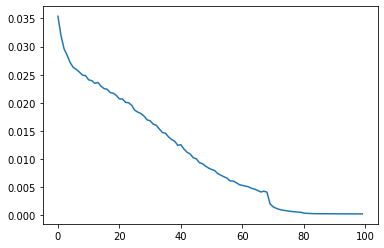

In [99]:
epochs = 100
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=2, min_lr=0.00001, verbose=1)

epoch_summarizer = EpochSummarizer(model, data_loader)
summarize = LambdaCallback(on_epoch_end=lambda epoch,logs: epoch_summarizer.summarize(epoch, logs))

fit_result = model.fit_generator(data_generator(data_loader, epochs), 
                                 steps_per_epoch=3*len(data_loader), 
                                 epochs=epochs, 
                                 verbose=1,
                                 callbacks=[
                                         reduce_lr,
                                         summarize
                                         ])
plt.plot(fit_result.history['loss'])

In [100]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


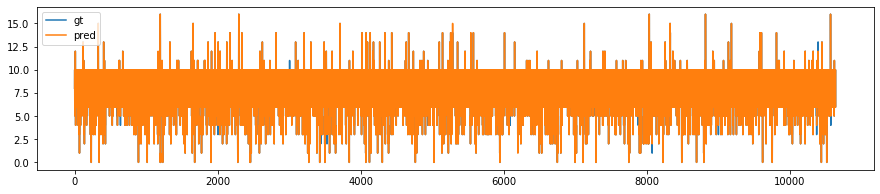

In [104]:
plt.figure(figsize=(15,3))
plt.plot(epoch_summarizer.data[99][:,3], label="gt")
plt.plot(epoch_summarizer.data[99][:,2], label="pred")
plt.legend()


In [111]:
def accuracy_e(epoch):
    data = epoch_summarizer.data[epoch]

    result = []
    for i,b in enumerate(epoch_summarizer.bins):
        gt_selctor = data[:,3]==i
        nom = np.sum([data[gt_selctor][:,2]==i])
        dnom = np.sum(gt_selctor)
        acc = "n/a"
        if dnom>0:
            acc = f"{(nom/dnom):0.3f}"
            result.append(nom/dnom)
        else:
            result.append(None)
        #print(f"Accuracy in bin {i}({b[0]:0.3f}-{b[1]:0.3f}): {acc}", nom, dnom)
    return np.array(result)
        

In [113]:
all_reuslts = []
for i in range(epochs):
    all_reuslts.append(accuracy_e(i))
all_reuslts = np.array(all_reuslts)

In [114]:
all_reuslts.shape

(100, 17)

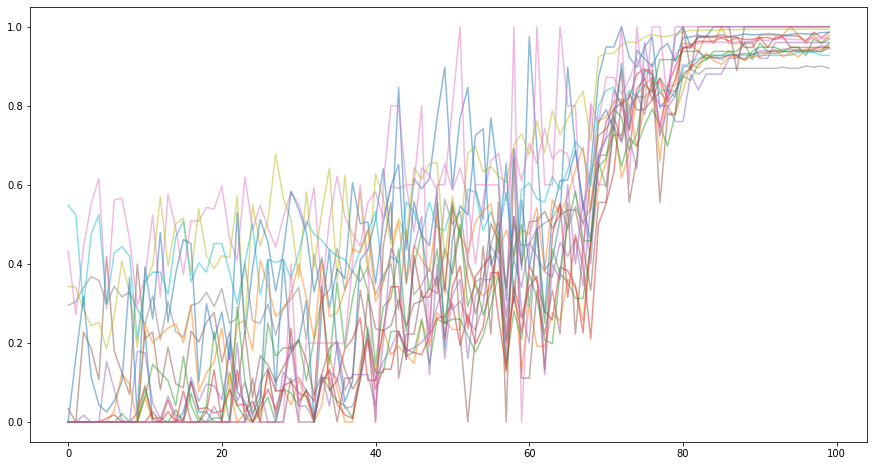

In [116]:
plt.figure(figsize=(15,8))
for i in range(all_reuslts.shape[1]):
    plt.plot(all_reuslts[:,i], label=f"bin {i}", alpha=0.5)

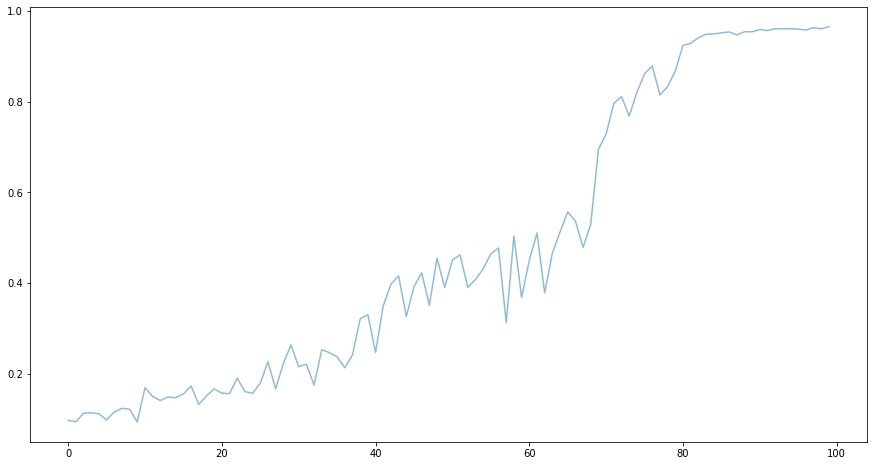

In [117]:
plt.figure(figsize=(15,8))
plt.plot(np.mean(all_reuslts, axis=1), label=f"bin {i}", alpha=0.5)